# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4.

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU.

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x)
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x)
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu121
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.71 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model.

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.9MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.93MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We analyse the data to check the number of samples and their size.

In [5]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article.

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model.

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.fc_layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.relu = nn.ReLU()


    def forward(self, x):
        x=x.view(x.size(0), -1)
        for layer in self.fc_layers[:-1]:
            x = self.relu(layer(x))
        x = self.fc_layers[-1](x)
        return x #no  softmax since we use the cross-entropy loss function where the softmax is intern ( we should give it raw logits)

**Question**: Create one of the model proposed in the article.

In [7]:
input_size = (28,28)
hidden_sizes = (100,100)
output_size = 10

# Model
model = FullyConnectedNet(
    input_size=input_size[0] * input_size[1],
    hidden_sizes=hidden_sizes,
    output_size=output_size
).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
  (relu): ReLU()
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [8]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [9]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [10]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 0.4105
Epoch [1/5], Step [200/235], Loss: 0.2465
Epoch [2/5], Step [100/235], Loss: 0.2456
Epoch [2/5], Step [200/235], Loss: 0.1558
Epoch [3/5], Step [100/235], Loss: 0.1480
Epoch [3/5], Step [200/235], Loss: 0.2276
Epoch [4/5], Step [100/235], Loss: 0.0665
Epoch [4/5], Step [200/235], Loss: 0.1742
Epoch [5/5], Step [100/235], Loss: 0.0973
Epoch [5/5], Step [200/235], Loss: 0.1687


In [11]:
evaluation(model, test_loader)

Accuracy of test images: 96.900000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model.

**Trying more complex approaches**

**Deeper architecture**

In [12]:
hidden_sizes1 = (784,512,256,128,64,32,16)

# Model
model1 = FullyConnectedNet(
    input_size=input_size[0] * input_size[1],
    hidden_sizes=hidden_sizes1,
    output_size=output_size
).to(device)
# Optimizer
optimizer = optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=weight_decay)

training(model1, train_loader, optimizer, num_epochs, loss_model)
evaluation(model1, test_loader)

Epoch [1/5], Step [100/235], Loss: 0.5303
Epoch [1/5], Step [200/235], Loss: 0.4053
Epoch [2/5], Step [100/235], Loss: 0.1416
Epoch [2/5], Step [200/235], Loss: 0.1708
Epoch [3/5], Step [100/235], Loss: 0.1320
Epoch [3/5], Step [200/235], Loss: 0.0854
Epoch [4/5], Step [100/235], Loss: 0.1173
Epoch [4/5], Step [200/235], Loss: 0.0613
Epoch [5/5], Step [100/235], Loss: 0.1052
Epoch [5/5], Step [200/235], Loss: 0.0928
Accuracy of test images: 97.070000 %


**Adding label-smoothing for regularization**

Even though it's not basically overfit, but supposing that we achieve 100% for the training set while 96-97% accuracy is achieved for validation set, we try to make it a little harder to the model to achieve perfect score on the training set in hope that he can improve further the 97% validation accuracy already attained. We increase the number of epochs as well to allow the model to learn more.

In [13]:
# Model
model2 = FullyConnectedNet(
    input_size=input_size[0] * input_size[1],
    hidden_sizes=hidden_sizes1,
    output_size=output_size
).to(device)
# Optimizer
optimizer2 = optim.Adam(model2.parameters(), lr=2e-3, weight_decay=weight_decay)

training(model2, train_loader, optimizer2, 10, nn.CrossEntropyLoss(label_smoothing=0.05))
evaluation(model2, test_loader)

Epoch [1/10], Step [100/235], Loss: 0.5952
Epoch [1/10], Step [200/235], Loss: 0.4601
Epoch [2/10], Step [100/235], Loss: 0.4213
Epoch [2/10], Step [200/235], Loss: 0.4164
Epoch [3/10], Step [100/235], Loss: 0.3800
Epoch [3/10], Step [200/235], Loss: 0.3566
Epoch [4/10], Step [100/235], Loss: 0.3658
Epoch [4/10], Step [200/235], Loss: 0.3082
Epoch [5/10], Step [100/235], Loss: 0.3170
Epoch [5/10], Step [200/235], Loss: 0.3290
Epoch [6/10], Step [100/235], Loss: 0.3539
Epoch [6/10], Step [200/235], Loss: 0.3330
Epoch [7/10], Step [100/235], Loss: 0.3128
Epoch [7/10], Step [200/235], Loss: 0.3128
Epoch [8/10], Step [100/235], Loss: 0.3065
Epoch [8/10], Step [200/235], Loss: 0.2976
Epoch [9/10], Step [100/235], Loss: 0.2943
Epoch [9/10], Step [200/235], Loss: 0.3257
Epoch [10/10], Step [100/235], Loss: 0.3026
Epoch [10/10], Step [200/235], Loss: 0.3101
Accuracy of test images: 97.970000 %


# **Answer**:

The simple architecture described in the paper—featuring two hidden layers with 100 neurons each-—achieved **96.9% accuracy** on the test dataset with just a few epochs of training.

When experimenting with deeper architectures and incorporating advanced techniques like label smoothing in the cross-entropy loss function, we observed only a slight improvement of roughly **1%**, resulting in a test accuracy of **97.97%**.

Based on the **Occam's Razor principle**, since we have similar performances, one prefers the simpler architecture, therefore we choose to continue with that approach.


Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [14]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=300
initial_c = 0.000001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

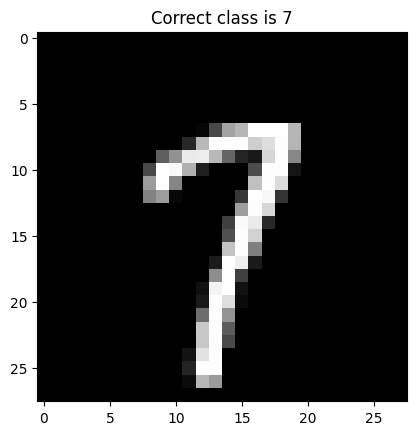

In [15]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [16]:
def plot_results(X, r, Xr, Y, l, fail=True):


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 7, the new class will be 1
Iter 20/300, Value of c: 0.000002
Iter 40/300, Value of c: 0.000003
Iter 60/300, Value of c: 0.000006
Iter 80/300, Value of c: 0.000011
Iter 100/300, Value of c: 0.000019
Iter 120/300, Value of c: 0.000035
Iter 140/300, Value of c: 0.000063
Iter 160/300, Value of c: 0.000113
Iter 180/300, Value of c: 0.000205
Iter 200/300, Value of c: 0.000369
Iter 220/300, Value of c: 0.000667
Iter 240/300, Value of c: 0.001205
Iter 260/300, Value of c: 0.002176
Iter 280/300, Value of c: 0.003930
Iter 300/300, Value of c: 0.007099
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 6457245.0


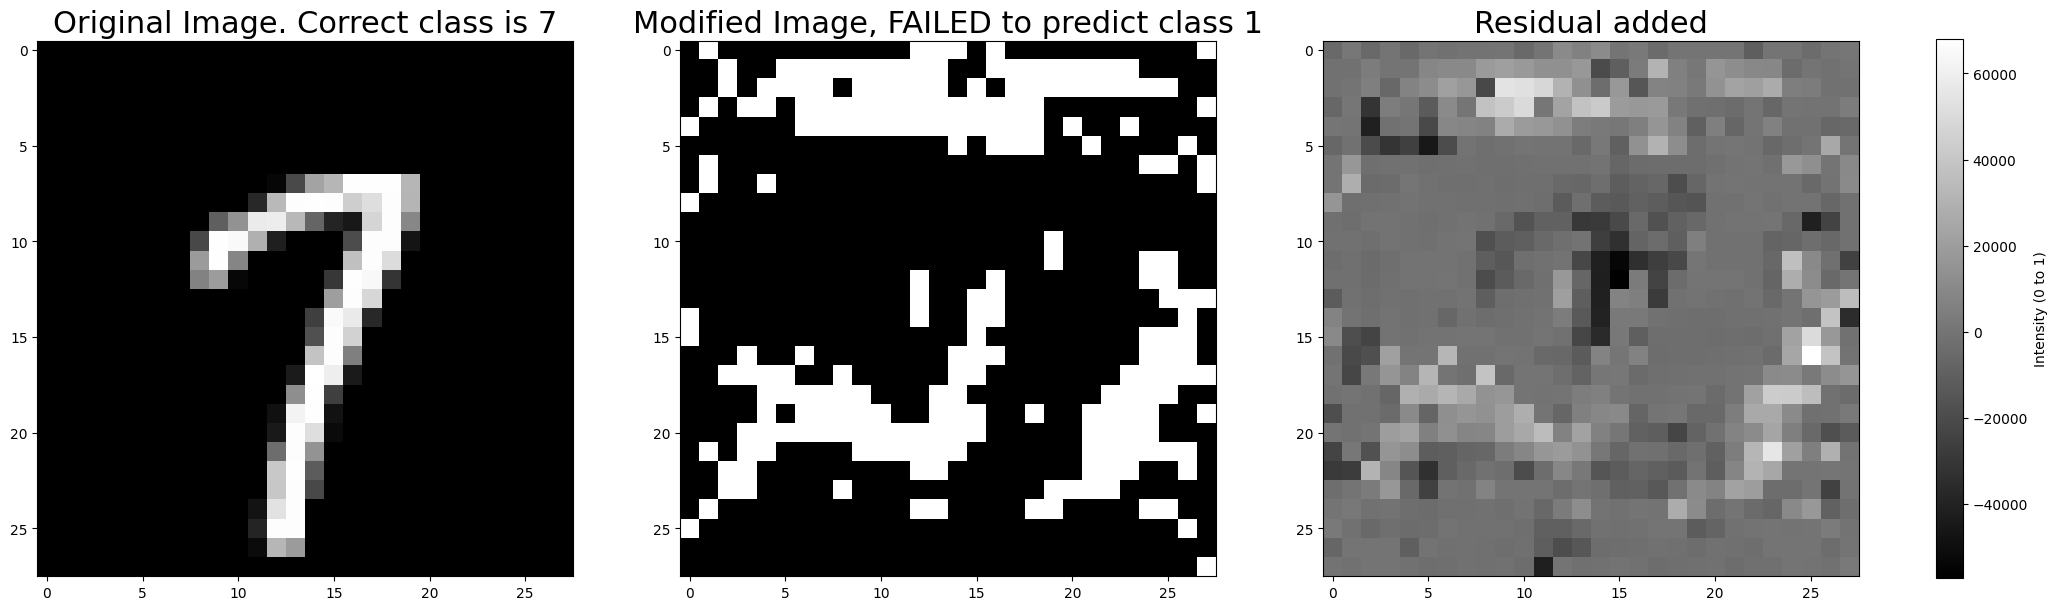

In [17]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label=1 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")



# Define the loss function
def objective(c, r, x, l):
    x_r = torch.clamp(x + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
    logits = model(x_r)  # Forward pass through the model
    loss = F.cross_entropy(logits, l)  # Cross-entropy loss for classification
    penalty = c * torch.norm(r, p=1)  # Add L1 norm penalty for |r|
    return penalty + loss


# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, tolerance_grad=epsilon_LBFGS)

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        break

    # If not satisfied, increase c
    c *= mult_c # Adjust step size for line search
    iter=iter+1
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?

To perform trials easily, we modularize the adversarial_optimization:

In [18]:
# Define the optimization process as a function
def adversarial_optimization(model, testI, testY, target_label, initial_c=initial_c, max_c=max_c, mult_c=mult_c, lr_LBFGS=lr_LBFGS, max_iter_LBFGS=max_iter_LBFGS, epsilon_LBFGS=epsilon_LBFGS, max_iter_search=max_iter_search):

    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    l = torch.tensor([target_label]).to(device).view(1)  # Target label in batch form

    print(f"The true class is {testY}, the new class will be {l[0]}")

    # Check initial prediction
    with torch.no_grad():
        pred = model(testI)
        predicted_label = torch.argmax(pred, dim=1)
        print(f"Initial prediction: {predicted_label.item()}, Target label: {l.item()}")

    # If the initial prediction already matches the target label, no optimization is needed
    if predicted_label.item() == l.item():
        print("The initial prediction already matches the target label. No optimization needed.")
        return r, testI, True, initial_c, 0

    # Line search to find the minimum c > 0
    c = initial_c
    iter_count = 0
    success = False

    while (c <= max_c) and (iter_count <= max_iter_search):
        optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, tolerance_grad=epsilon_LBFGS)

        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        if predicted_label.item() == l.item():
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            success = True
            break

        # If not satisfied, increase c
        c *= mult_c
        iter_count += 1
        if iter_count % 20 == 0:
            print(f'Iter {iter_count}/{max_iter_search}, Value of c: {c:.6f}, Norm of r: {torch.norm(r, p=1):.2f}')

    return r, x_r, success, c, iter_count,l



Trying it with the previous setting:

The true class is 7, the new class will be 1
Initial prediction: 7, Target label: 1
Iter 20/300, Value of c: 0.000002, Norm of r: 6457254.00
Iter 40/300, Value of c: 0.000003, Norm of r: 6457254.00
Iter 60/300, Value of c: 0.000006, Norm of r: 6457254.00
Iter 80/300, Value of c: 0.000011, Norm of r: 6457254.00
Iter 100/300, Value of c: 0.000019, Norm of r: 6457254.00
Iter 120/300, Value of c: 0.000035, Norm of r: 6457254.00
Iter 140/300, Value of c: 0.000063, Norm of r: 6457254.00
Iter 160/300, Value of c: 0.000113, Norm of r: 6457254.00
Iter 180/300, Value of c: 0.000205, Norm of r: 6457254.00
Iter 200/300, Value of c: 0.000369, Norm of r: 6457254.00
Iter 220/300, Value of c: 0.000667, Norm of r: 6457253.50
Iter 240/300, Value of c: 0.001205, Norm of r: 6457253.00
Iter 260/300, Value of c: 0.002176, Norm of r: 6457252.00
Iter 280/300, Value of c: 0.003930, Norm of r: 6457249.50
Iter 300/300, Value of c: 0.007099, Norm of r: 6457245.50
Failed to find c satisfying f(x + r) = l within th

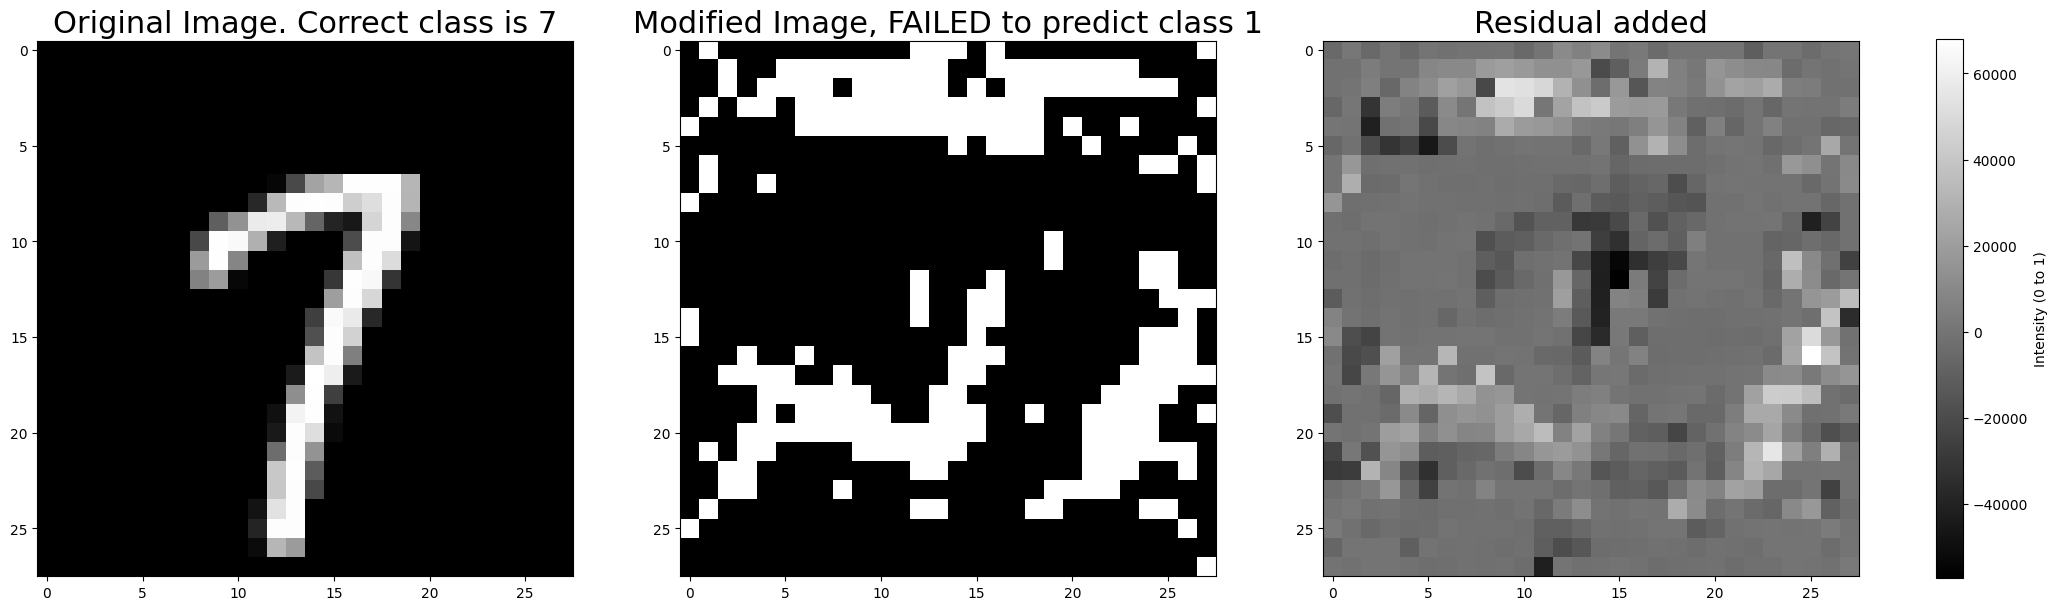

In [19]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI.to(device),
    testY=testY,
    target_label=1,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI, r, x_r, testY, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI, r, x_r, testY, l, fail=True)

Trying other images

In [20]:
index_1, index_2 = 444, 555

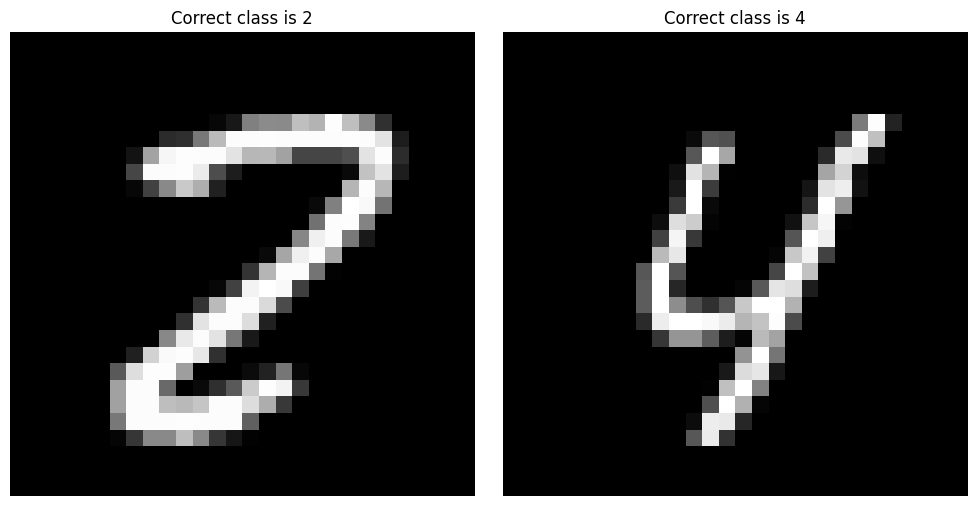

In [21]:
testI_1, testY_1 = mnist_test.__getitem__(index_1)
testI_2, testY_2 = mnist_test.__getitem__(index_2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image
axes[0].imshow(testI_1.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
axes[0].set_title(f"Correct class is {testY_1}")
axes[0].axis("off")  # Remove axis for better display

# Plot the second image
axes[1].imshow(testI_2.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
axes[1].set_title(f"Correct class is {testY_2}")
axes[1].axis("off")  # Remove axis for better display

# Display the plot
plt.tight_layout()
plt.show()


The true class is 2, the new class will be 1
Initial prediction: 2, Target label: 1
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 119.08


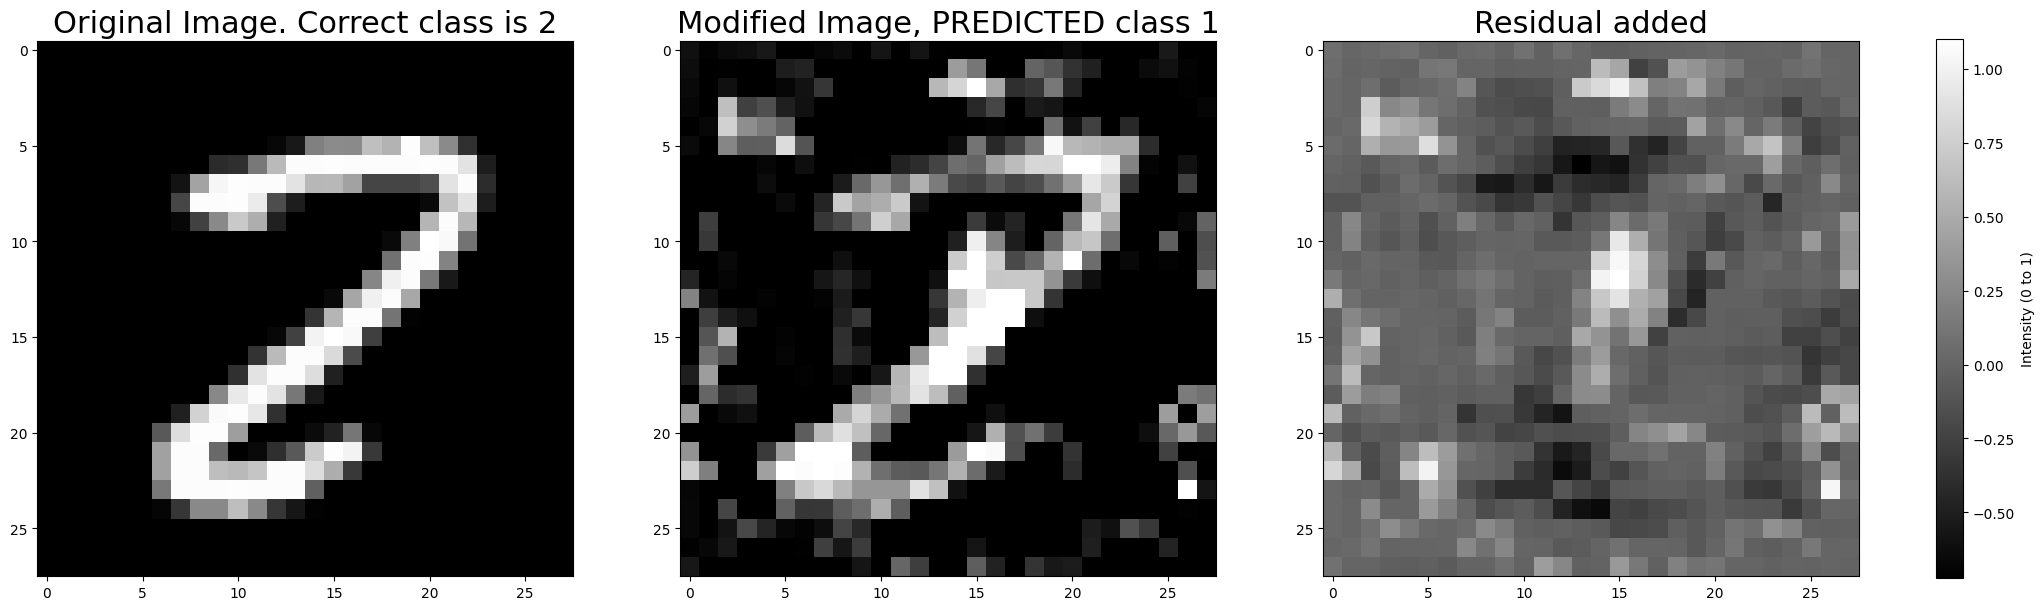

In [22]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_1.to(device),
    testY=testY_1,
    target_label=1,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=True)

The true class is 4, the new class will be 1
Initial prediction: 4, Target label: 1
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 100.46


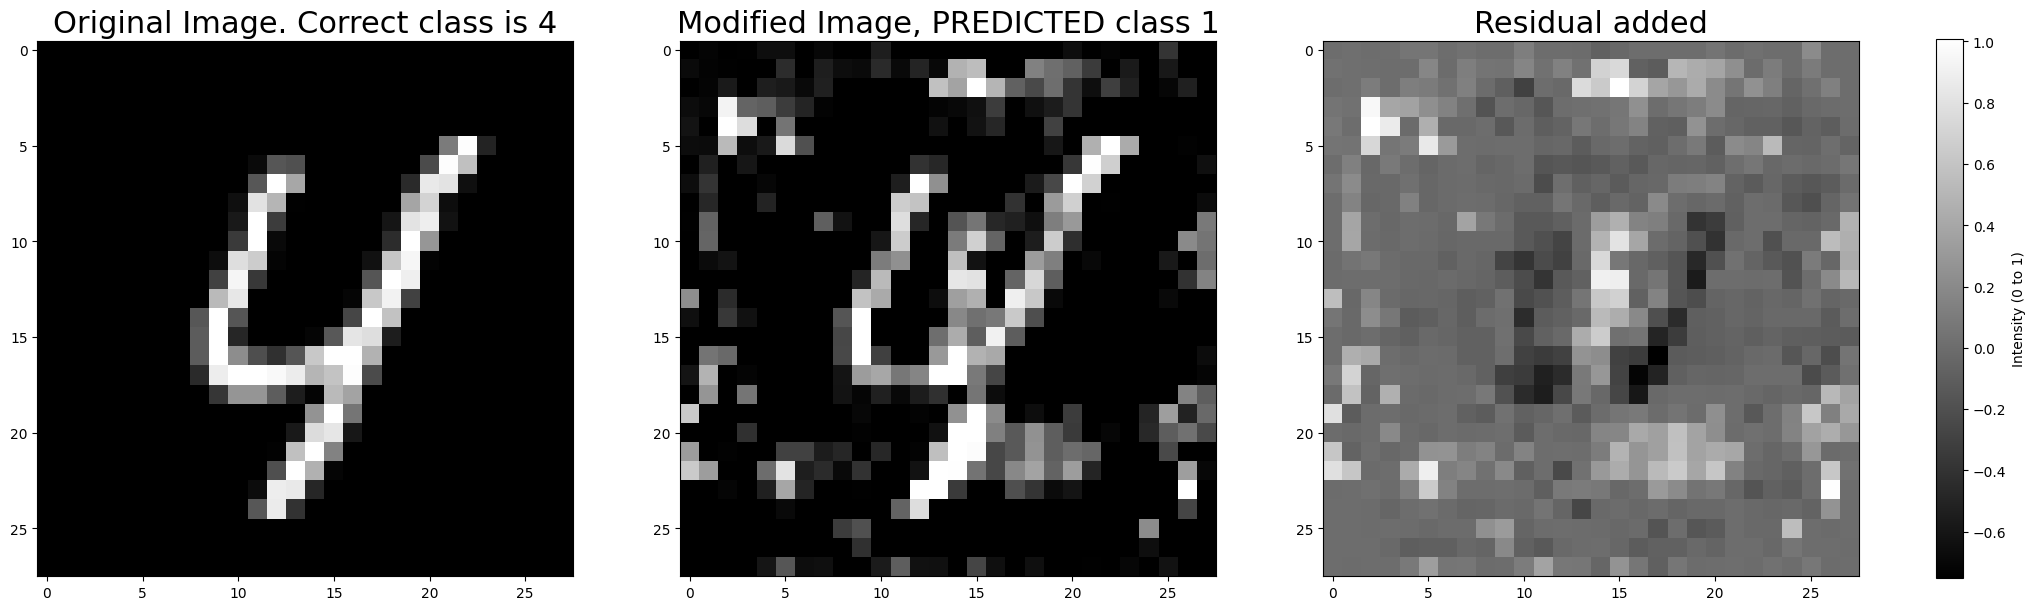

In [23]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_2.to(device),
    testY=testY_2,
    target_label=1,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=True)

Really bad results for these classes, maybe we should try others predicted classes that are closer to 2 and 4 rather than 1 which were a better option when we had 7.Maybe we can try to make the new label 8  for 2 and 9 or 5 for 4.

The true class is 2, the new class will be 8
Initial prediction: 2, Target label: 8
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 44.01


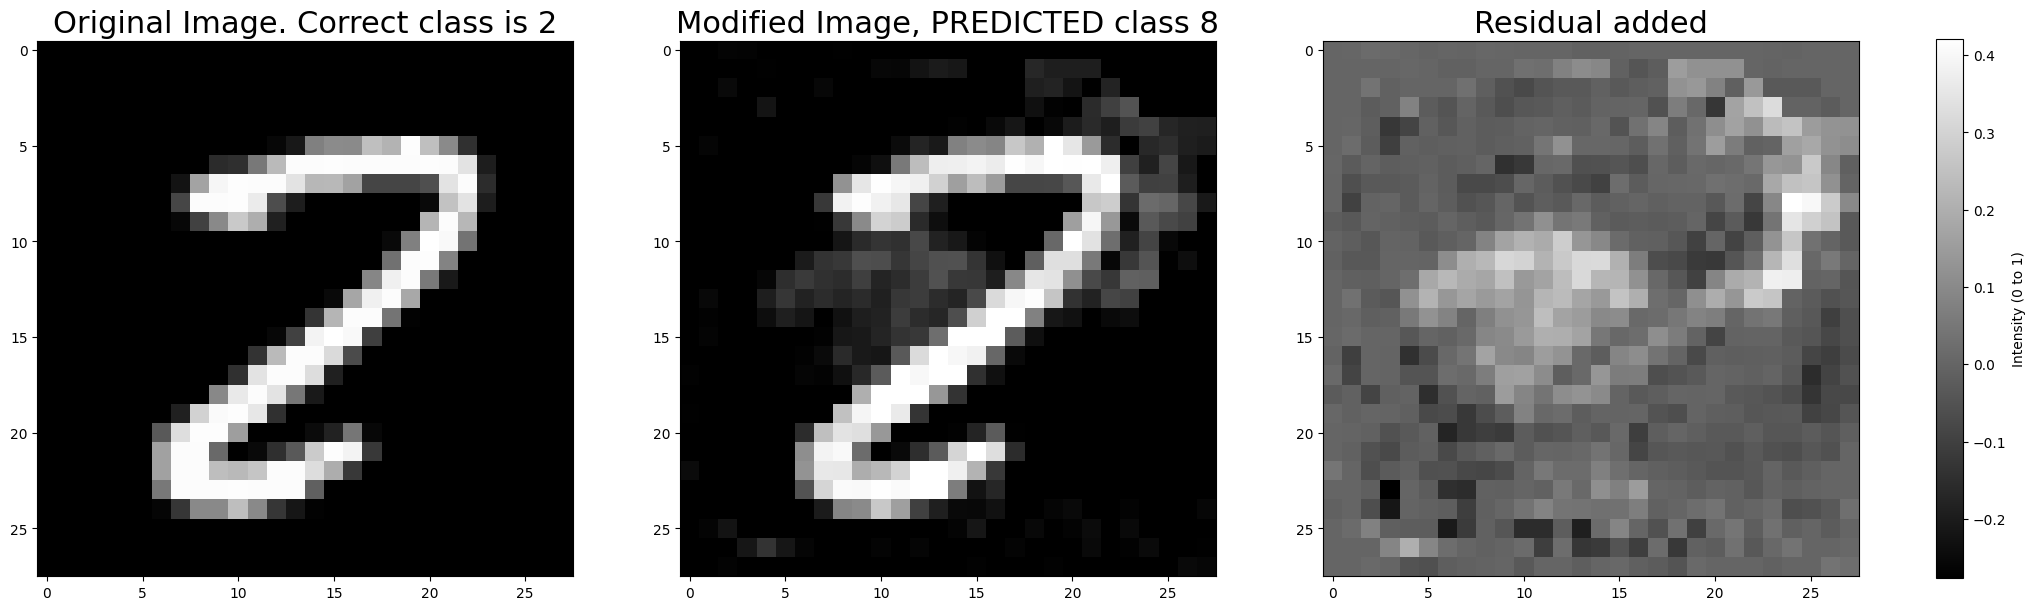

In [24]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_1.to(device),
    testY=testY_1,
    target_label=8,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=True)

The true class is 4, the new class will be 9
Initial prediction: 4, Target label: 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 48.00


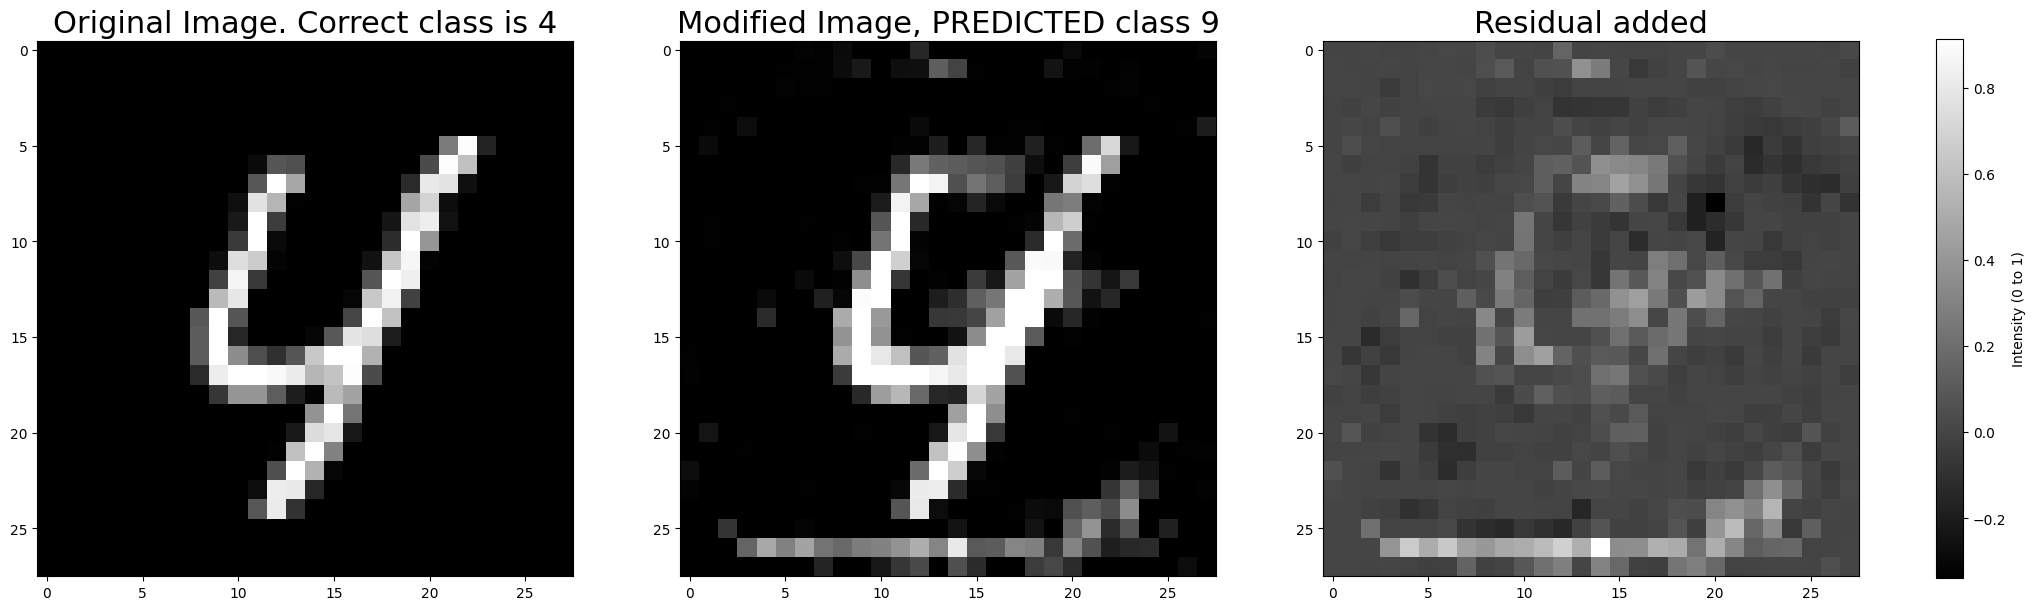

In [25]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_2.to(device),
    testY=testY_2,
    target_label=9,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=True)

Still bad results, the value of r is too high, maybe we should change the paramater c, since if we have a bigger c, r becomes smaller, thus the change shoudl not distort the semantic meaning of the image.

The true class is 2, the new class will be 8
Initial prediction: 2, Target label: 8
Found c = 0.010000 satisfying f(x + r) = l
Optimization succeeded with c = 0.010000 in 0 iterations
Norm Perturbation |r|: 14.61


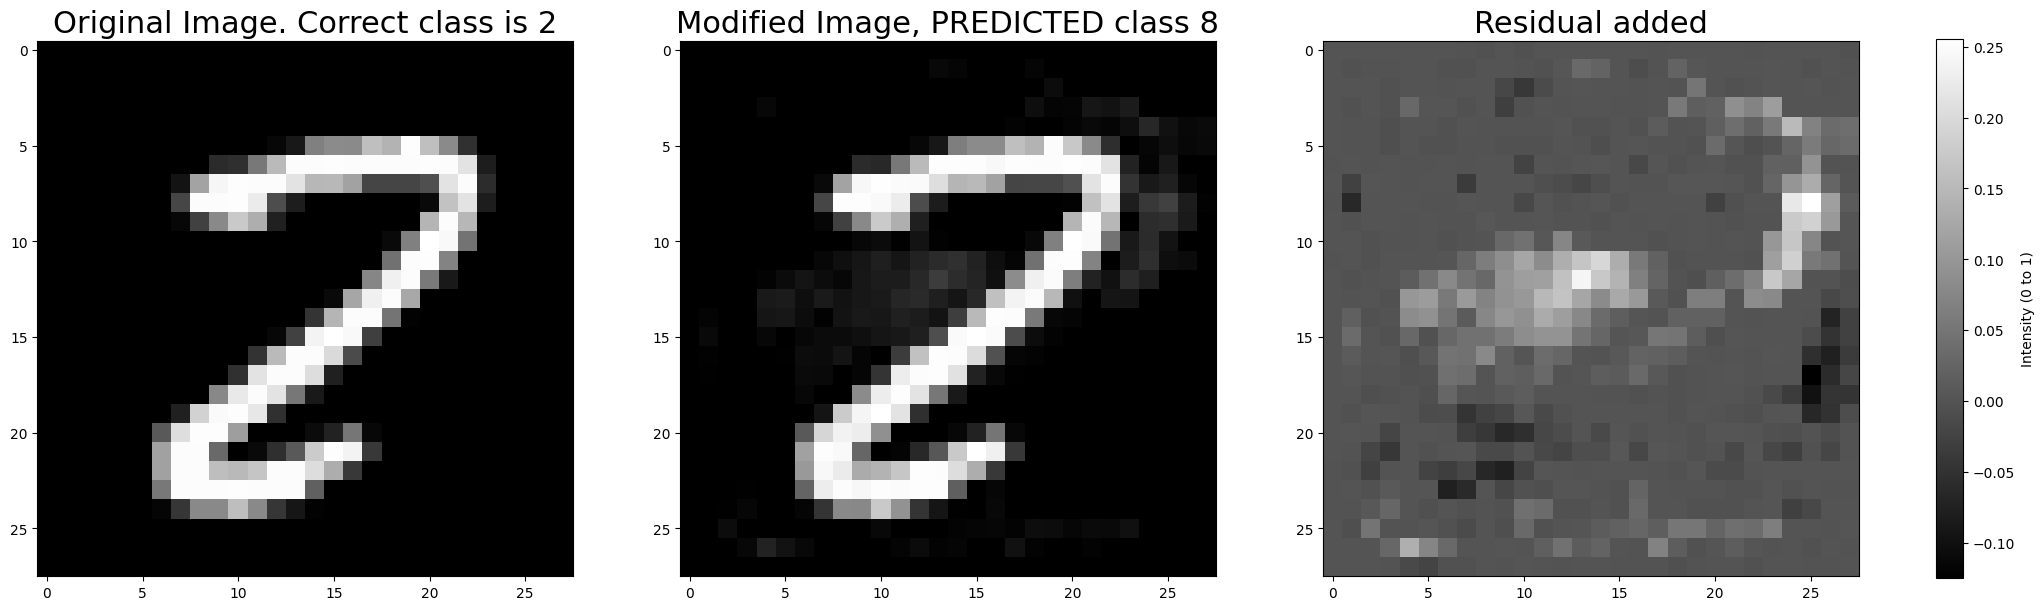

In [26]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_1.to(device),
    testY=testY_1,
    target_label=8,
    initial_c=0.01,
    max_c=0.1
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=True)

The true class is 4, the new class will be 9
Initial prediction: 4, Target label: 9
Found c = 0.010000 satisfying f(x + r) = l
Optimization succeeded with c = 0.010000 in 0 iterations
Norm Perturbation |r|: 8.95


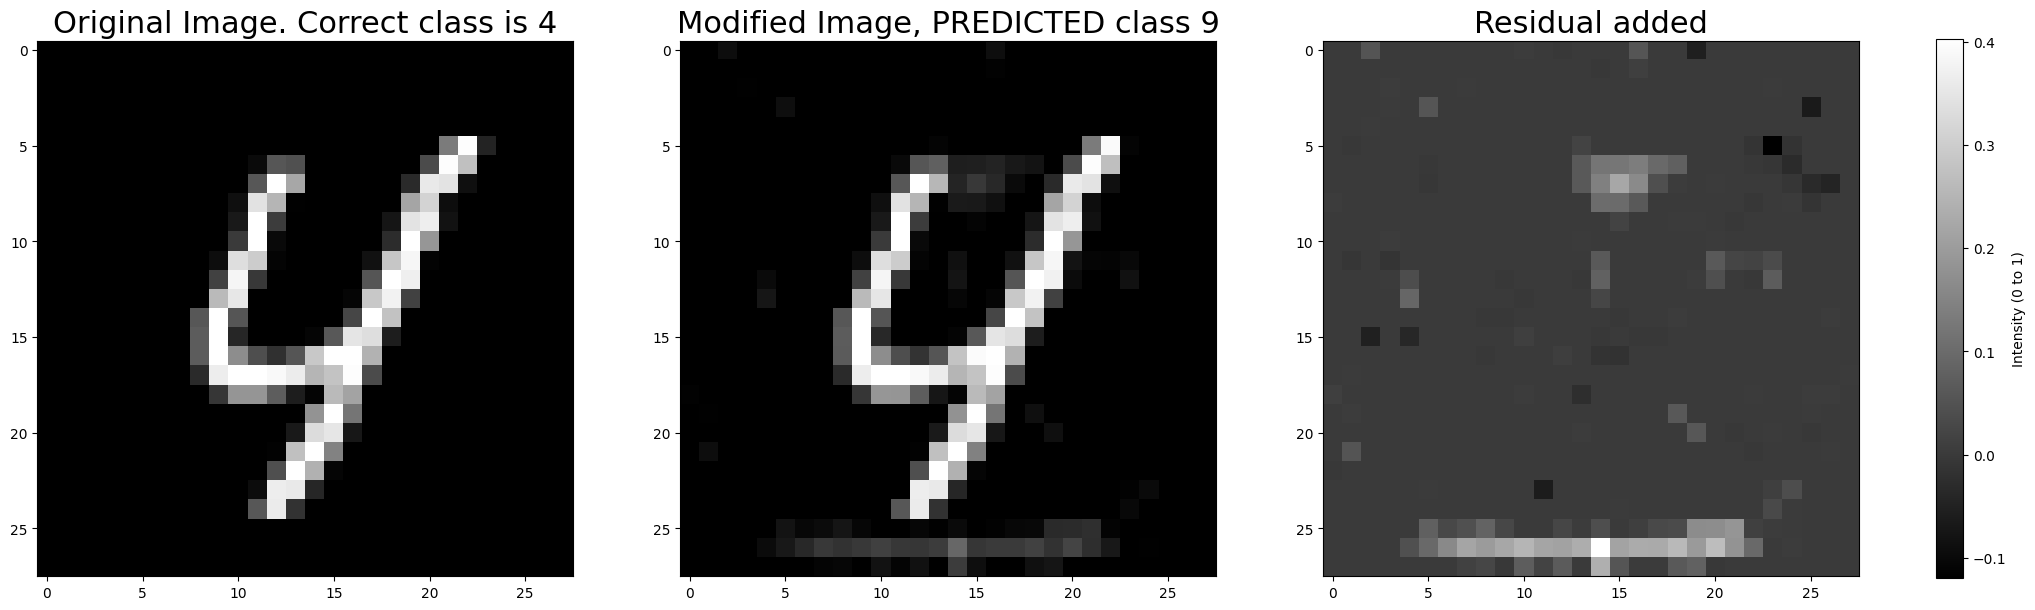

In [27]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_2.to(device),
    testY=testY_2,
    target_label=9,
    initial_c=0.01,
    max_c=0.1
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=True)

This is much better. These results indeed provides an adversial examples since semantically a human can be overconfident of the label of the modified image, however the model is no longer confident in his intial prediction.

$|r|$ doesn't seem to have a very good avearge, it looks like it's always big if we initialize the c with small values like $1e-6$ or $1e-7$, while it's much better for bigger values of initial_c like $0.01$ or $0.001$, where we find r with the same magnitude of 10 or 100.

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed.

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

Trying the two other networks:

The true class is 7, the new class will be 1
Initial prediction: 7, Target label: 1
Found c = 0.000106 satisfying f(x + r) = l
Optimization succeeded with c = 0.000106 in 2 iterations
Norm Perturbation |r|: 31.49


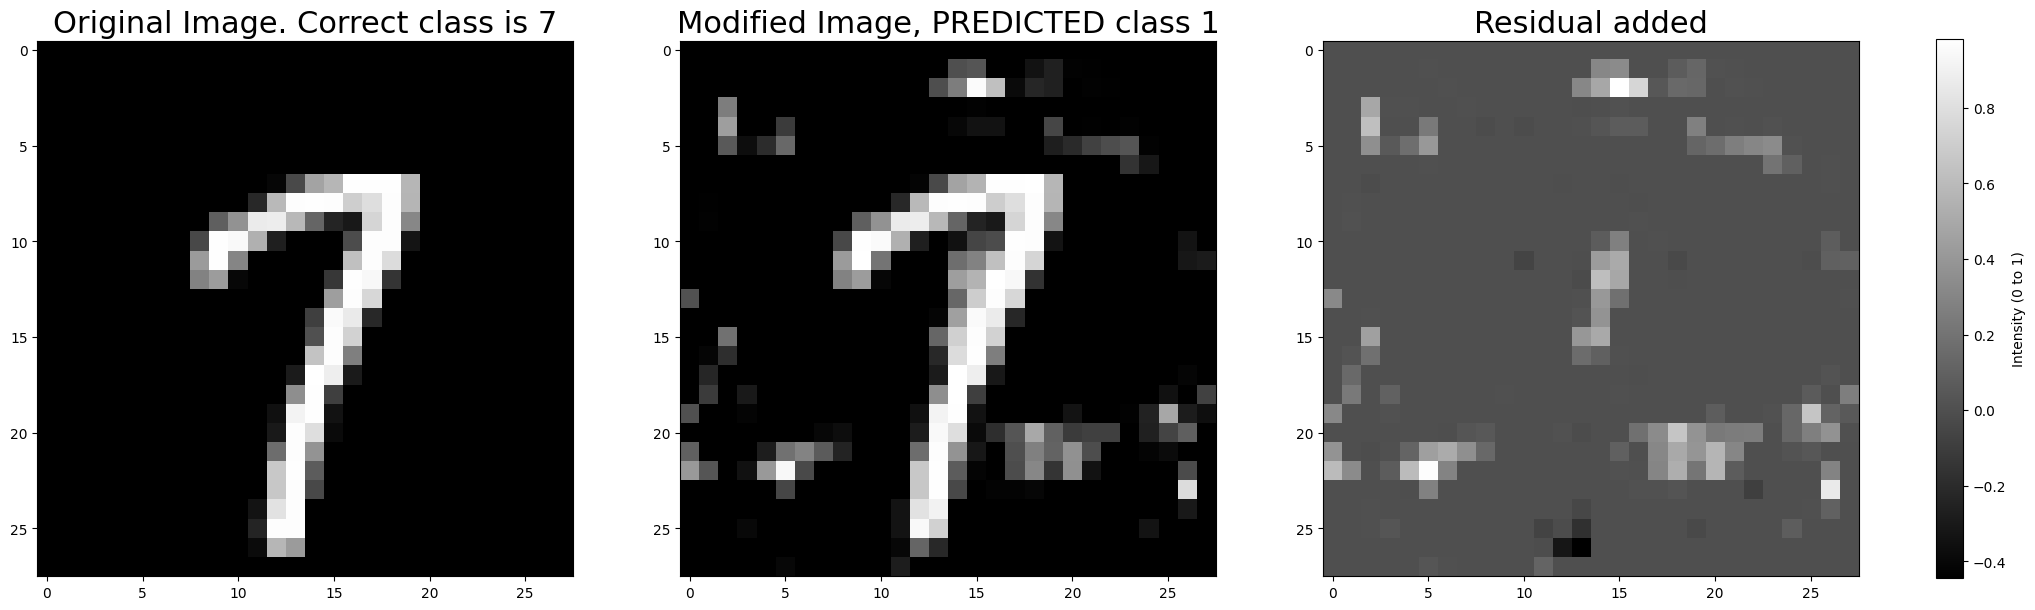

The true class is 2, the new class will be 8
Initial prediction: 2, Target label: 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 29.82


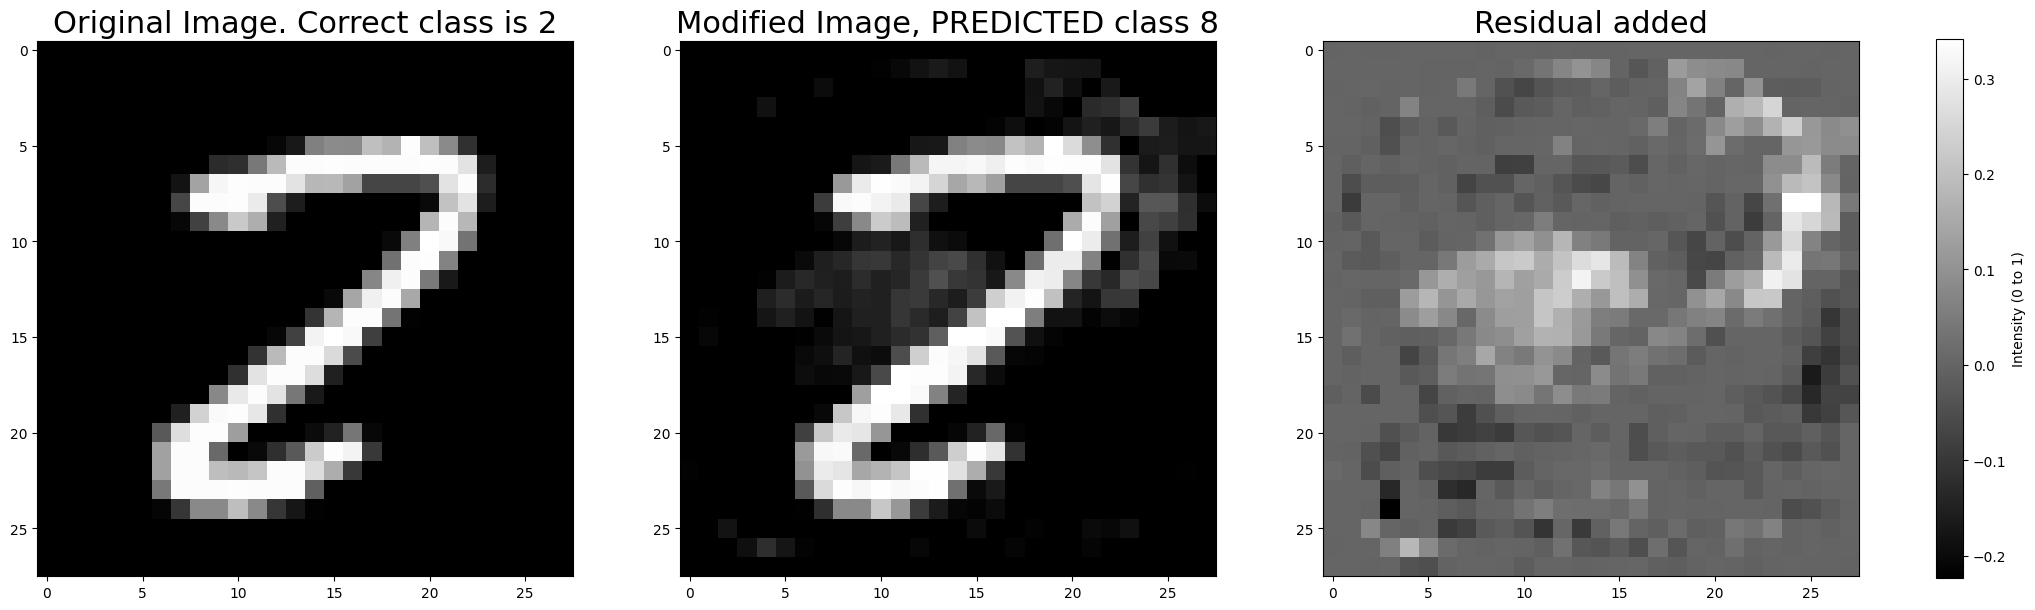

The true class is 4, the new class will be 9
Initial prediction: 4, Target label: 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 48.00


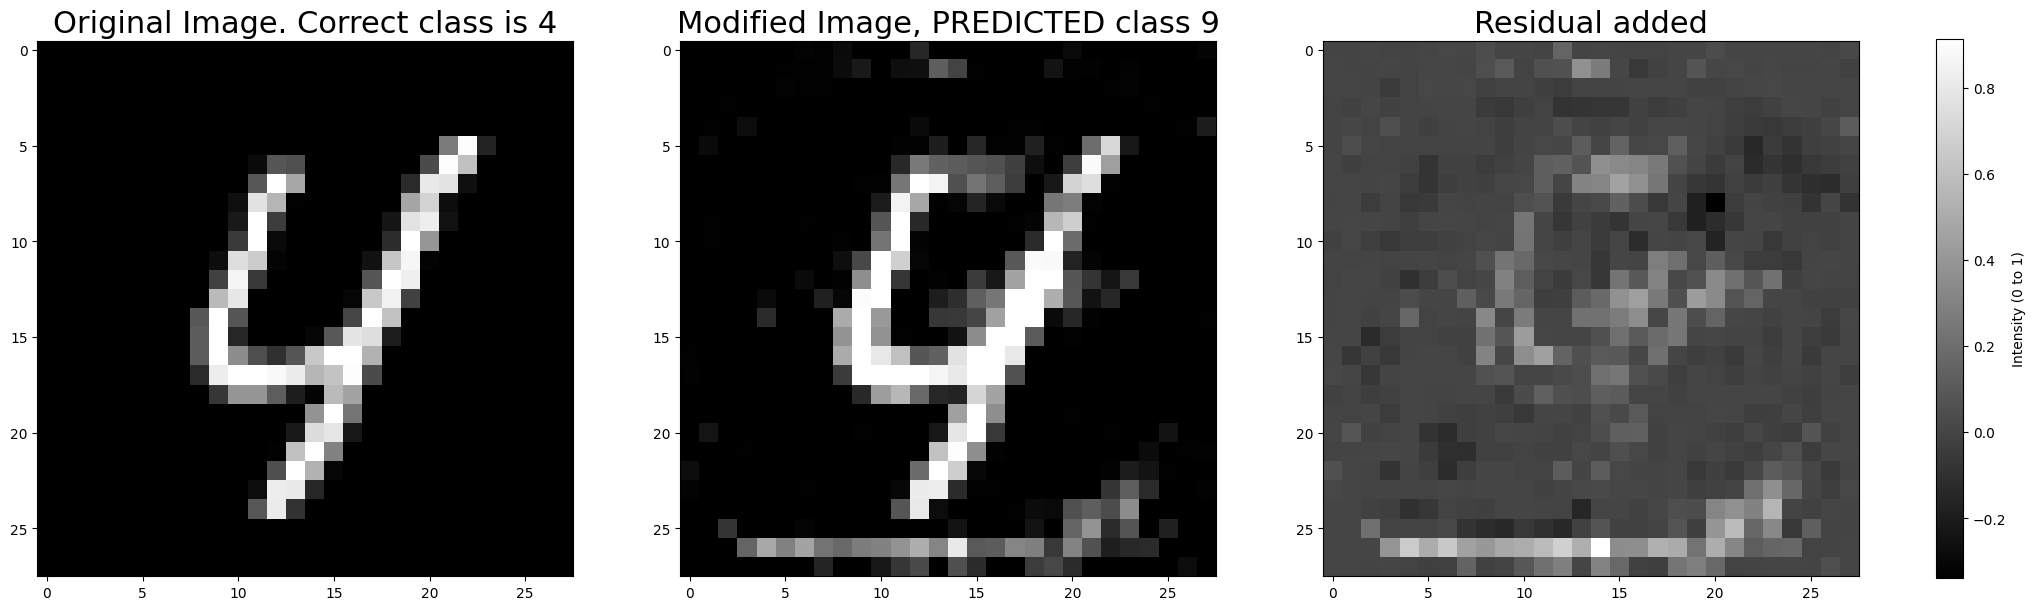

In [28]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model1,
    testI=testI.to(device),
    testY=testY,
    target_label=1,
    initial_c=0.0001,
    max_c=0.1
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI, r, x_r, testY, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI, r, x_r, testY, l, fail=True)

# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model1,
    testI=testI_1.to(device),
    testY=testY_1,
    target_label=8,
    initial_c=0.0001,
    max_c=0.1
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=True)

# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model1,
    testI=testI_2.to(device),
    testY=testY_2,
    target_label=9,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=True)

The true class is 7, the new class will be 1
Initial prediction: 7, Target label: 1
Iter 20/300, Value of c: 0.000002, Norm of r: 6457254.00
Iter 40/300, Value of c: 0.000003, Norm of r: 6457254.00
Iter 60/300, Value of c: 0.000006, Norm of r: 6457254.00
Iter 80/300, Value of c: 0.000011, Norm of r: 6457254.00
Iter 100/300, Value of c: 0.000019, Norm of r: 6457254.00
Iter 120/300, Value of c: 0.000035, Norm of r: 6457254.00
Iter 140/300, Value of c: 0.000063, Norm of r: 6457254.00
Iter 160/300, Value of c: 0.000113, Norm of r: 6457254.00
Iter 180/300, Value of c: 0.000205, Norm of r: 6457254.00
Iter 200/300, Value of c: 0.000369, Norm of r: 6457254.00
Iter 220/300, Value of c: 0.000667, Norm of r: 6457253.50
Iter 240/300, Value of c: 0.001205, Norm of r: 6457253.00
Iter 260/300, Value of c: 0.002176, Norm of r: 6457252.00
Iter 280/300, Value of c: 0.003930, Norm of r: 6457249.50
Iter 300/300, Value of c: 0.007099, Norm of r: 6457245.50
Failed to find c satisfying f(x + r) = l within th

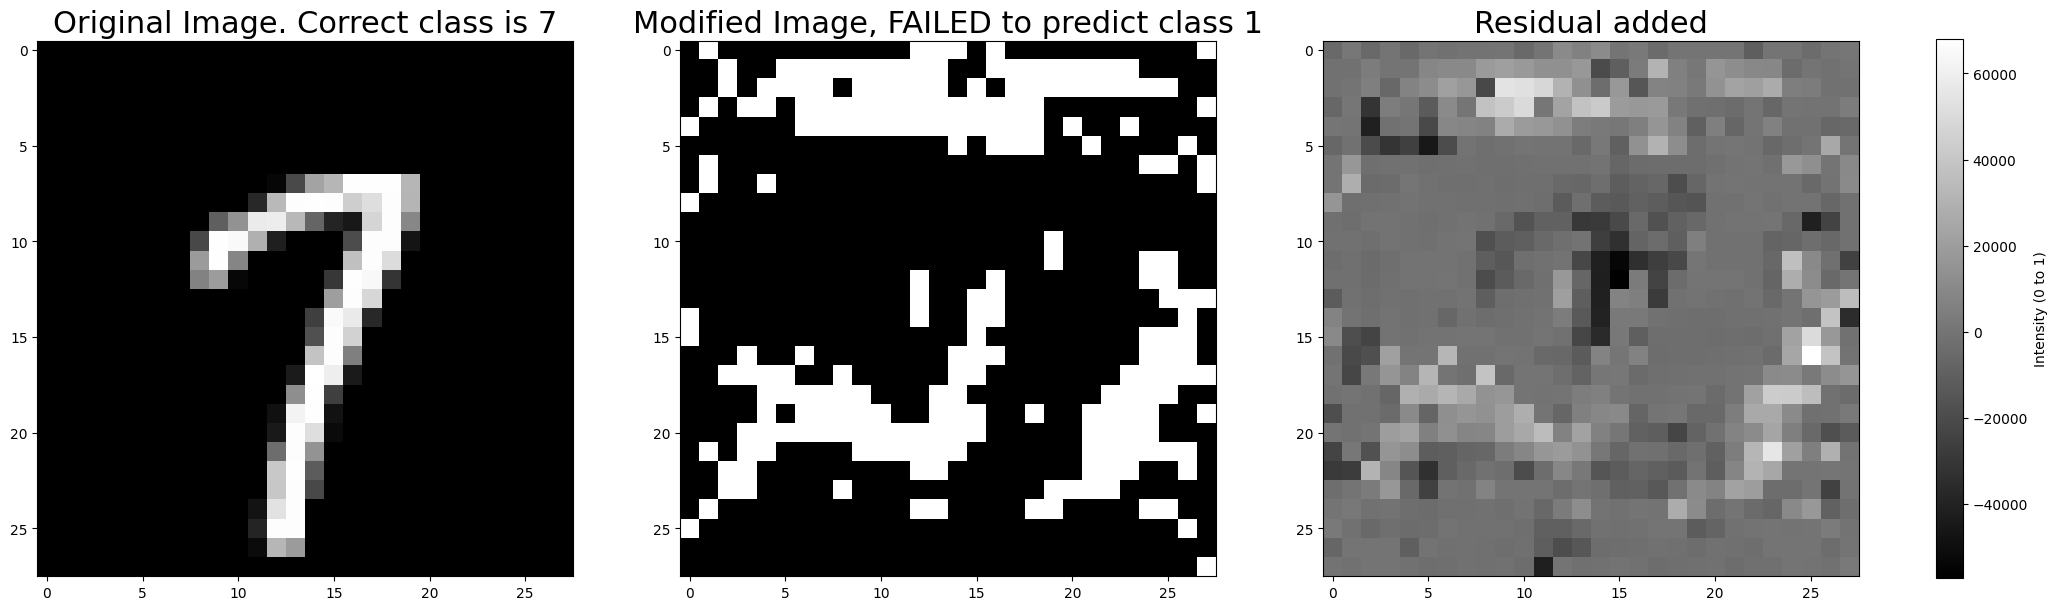

The true class is 2, the new class will be 8
Initial prediction: 2, Target label: 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 29.82


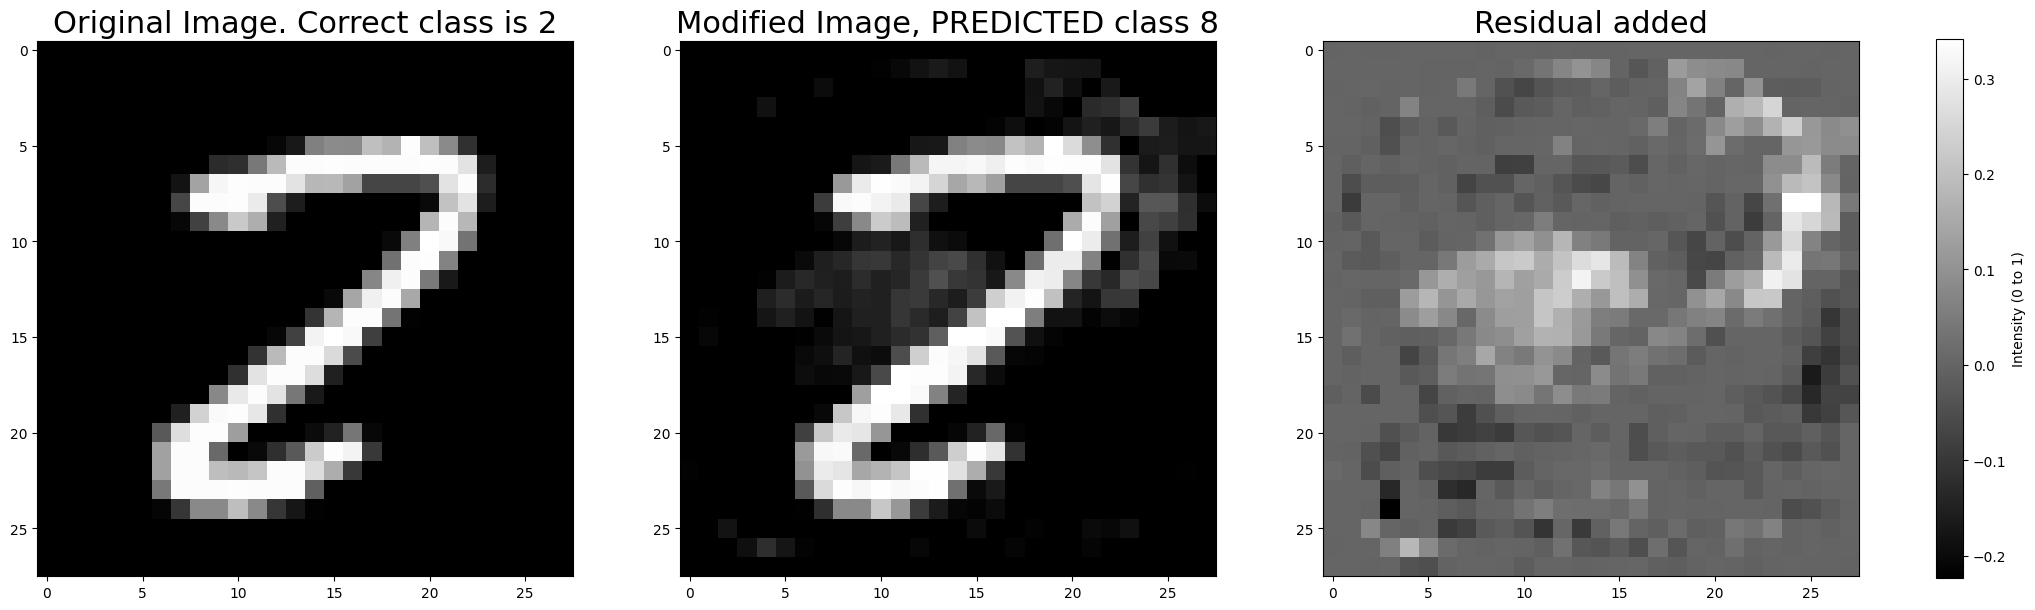

The true class is 4, the new class will be 9
Initial prediction: 4, Target label: 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 48.00


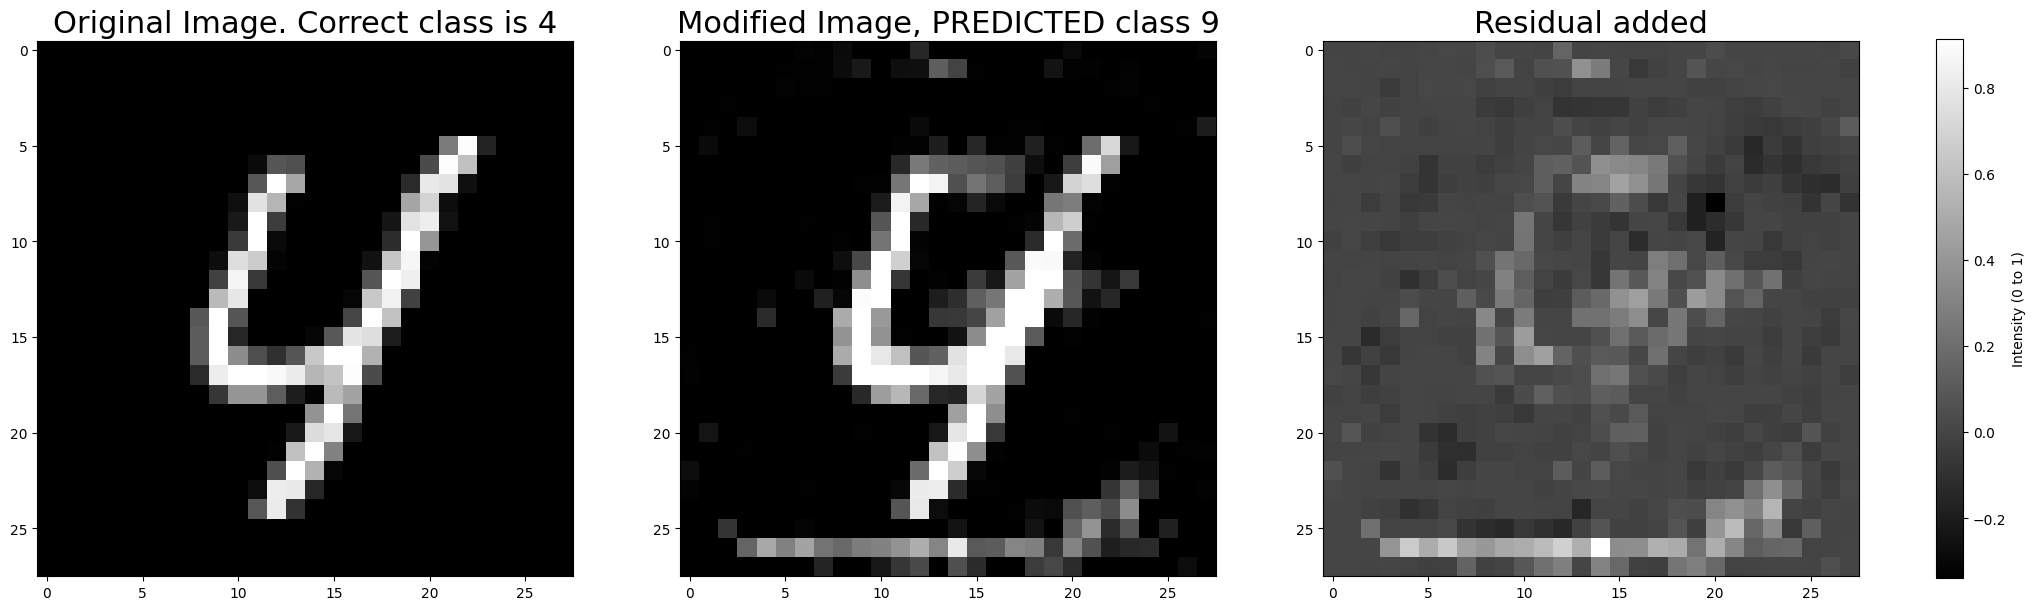

In [29]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model2,
    testI=testI.to(device),
    testY=testY,
    target_label=1,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI, r, x_r, testY, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI, r, x_r, testY, l, fail=True)

# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model2,
    testI=testI_1.to(device),
    testY=testY_1,
    target_label=8,
    initial_c=0.0001,
    max_c=0.1
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_1, r, x_r, testY_1, l, fail=True)

# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model2,
    testI=testI_2.to(device),
    testY=testY_2,
    target_label=9,
)

# Print results
if success:
    print(f"Optimization succeeded with c = {final_c:.6f} in {iter_count} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=False)
else:
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iterations.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.2f}")
    plot_results(testI_2, r, x_r, testY_2, l, fail=True)

Well, seemingly, we need further finetuning to our hyperparameters of the examples of images 7 and 4, however , the image with label 2 seems like a promising adversarial example for all 3 networks, let's verify this with the image modified by the 1st network.

In [30]:
# Perform the adversarial optimization
r, x_r, success, final_c, iter_count,l = adversarial_optimization(
    model=model,
    testI=testI_1.to(device),
    testY=testY_1,
    target_label=8,
    initial_c=0.0001,
    max_c=0.1
)

The true class is 2, the new class will be 8
Initial prediction: 2, Target label: 8
Found c = 0.000100 satisfying f(x + r) = l


In [31]:
pred_0 = model(x_r)
predicted_label_0 = torch.argmax(pred_0, dim=1)
print(f"prediction: {predicted_label_0.item()}, Target label: {l[0]}")

pred_1 = model1(x_r)
predicted_label_1 = torch.argmax(pred_1, dim=1)
print(f"prediction: {predicted_label_1.item()}, Target label: {l[0]}")

pred_2 = model2(x_r)
predicted_label_2 = torch.argmax(pred_2, dim=1)
print(f"prediction: {predicted_label_2.item()}, Target label: {l[0]}")

prediction: 8, Target label: 8
prediction: 8, Target label: 8
prediction: 8, Target label: 8


Thus, we indeed were able to fool all of the three networks with the adversial example obtained from the optimization using only the 1st network.

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c.

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

In [32]:
# Parameters for Adam optimization
fixed_c = 0.001  # Fixing c for the first method
lr_adam = 0.01   # Learning rate for Adam
max_iter_adam = 300  # Maximum iterations for Adam

# Modified adversarial optimization function using Adam
def adversarial_optimization_adam(model, testI, testY, target_label, optimize_c=False, fixed_c=fixed_c, lr_adam=lr_adam, max_iter_adam=max_iter_adam, reg_lambda=0.01):
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    c = torch.tensor(fixed_c, requires_grad=optimize_c, device=device)  # Initialize c (optimized if required)
    l = torch.tensor([target_label]).to(device).view(1)  # Target label in batch form

    print(f"The true class is {testY}, the new class will be {l[0]}")

    # Check initial prediction
    with torch.no_grad():
        pred = model(testI)
        predicted_label = torch.argmax(pred, dim=1)
        print(f"Initial prediction: {predicted_label.item()}, Target label: {l.item()}")

    # If the initial prediction already matches the target label, no optimization is needed
    if predicted_label.item() == l.item():
        print("The initial prediction already matches the target label. No optimization needed.")
        return r, testI, True, fixed_c, 0

    # Define the optimizer
    params = [r]
    if optimize_c:
        params.append(c)  # Include c in the optimization if required
    optimizer = optim.Adam(params, lr=lr_adam)

    # Adversarial optimization loop
    iter_count = 0
    success = False

    for _ in range(max_iter_adam):
        optimizer.zero_grad()

        # Compute the objective
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        logits = model(x_r)

        # Cross-entropy loss for the target class
        target_loss = nn.CrossEntropyLoss()(logits, l)

        # Regularization term (L2 norm of r)
        reg_loss = reg_lambda * torch.norm(r, p=2)

        # Combined loss
        if optimize_c:
            loss = c * target_loss + reg_loss
        else:
            loss = fixed_c * target_loss + reg_loss

        loss.backward()
        optimizer.step()

        # Evaluate if the target class is achieved
        with torch.no_grad():
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)
            if predicted_label.item() == l.item():
                print(f"Success at iteration {iter_count + 1}: Adversarial example found with norm {torch.norm(r, p=2):.4f}")
                success = True
                break

        iter_count += 1
        if iter_count % 20 == 0:
            print(f'Iter {iter_count}/{max_iter_adam}, Loss: {loss.item():.6f}, Norm of r: {torch.norm(r, p=2):.4f}')

    return r, x_r, success, c.item() if optimize_c else fixed_c, iter_count



Fixed c, optimizing r:
The true class is 7, the new class will be 1
Initial prediction: 7, Target label: 1
Iter 20/300, Loss: 0.008539, Norm of r: 0.0502
Iter 40/300, Loss: 0.008322, Norm of r: 0.0313
Iter 60/300, Loss: 0.008279, Norm of r: 0.0242
Iter 80/300, Loss: 0.008267, Norm of r: 0.0211
Iter 100/300, Loss: 0.008266, Norm of r: 0.0201
Iter 120/300, Loss: 0.008260, Norm of r: 0.0167
Iter 140/300, Loss: 0.008263, Norm of r: 0.0190
Iter 160/300, Loss: 0.008265, Norm of r: 0.0195
Iter 180/300, Loss: 0.008261, Norm of r: 0.0178
Iter 200/300, Loss: 0.008260, Norm of r: 0.0166
Iter 220/300, Loss: 0.008263, Norm of r: 0.0196
Iter 240/300, Loss: 0.008260, Norm of r: 0.0168
Iter 260/300, Loss: 0.008255, Norm of r: 0.0163
Iter 280/300, Loss: 0.008253, Norm of r: 0.0166
Iter 300/300, Loss: 0.008259, Norm of r: 0.0197


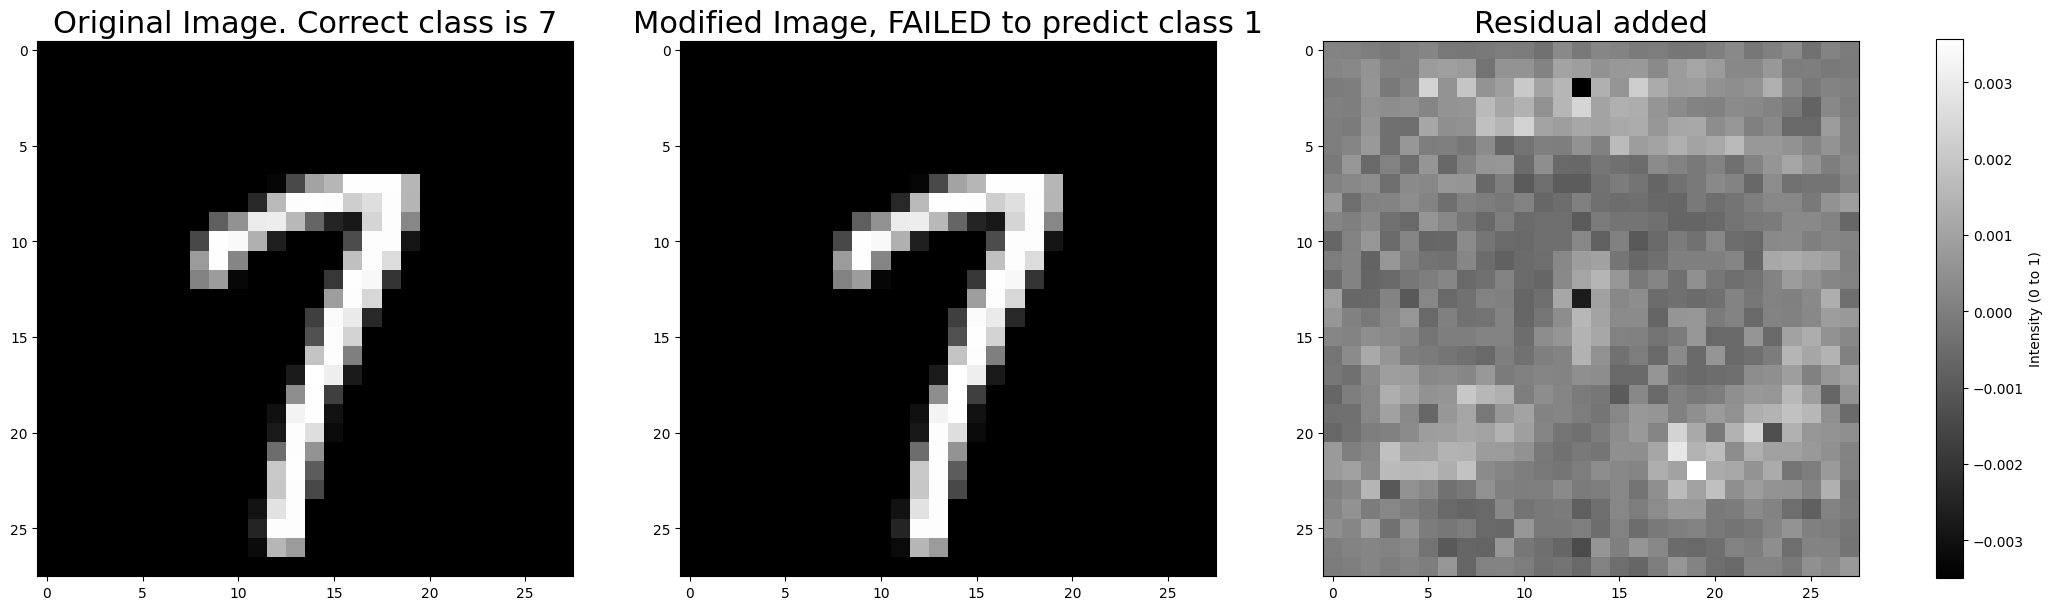


Optimizing both c and r:
The true class is 7, the new class will be 1
Initial prediction: 7, Target label: 1
Iter 20/300, Loss: -3.554903, Norm of r: 2.9655
Iter 40/300, Loss: -14.216830, Norm of r: 7.2778
Iter 60/300, Loss: -34.845142, Norm of r: 12.1899
Iter 80/300, Loss: -67.396912, Norm of r: 17.2944
Iter 100/300, Loss: -89.656540, Norm of r: 19.9407
Iter 120/300, Loss: -109.181519, Norm of r: 20.5298
Iter 140/300, Loss: -127.387299, Norm of r: 20.6535
Iter 160/300, Loss: -144.650543, Norm of r: 20.6464
Iter 180/300, Loss: -161.341782, Norm of r: 20.5935
Iter 200/300, Loss: -177.619461, Norm of r: 20.5327
Iter 220/300, Loss: -193.584229, Norm of r: 20.4707
Iter 240/300, Loss: -209.340561, Norm of r: 20.4138
Iter 260/300, Loss: -225.051178, Norm of r: 20.3714
Iter 280/300, Loss: -240.544556, Norm of r: 20.3439
Iter 300/300, Loss: -255.832916, Norm of r: 20.3135


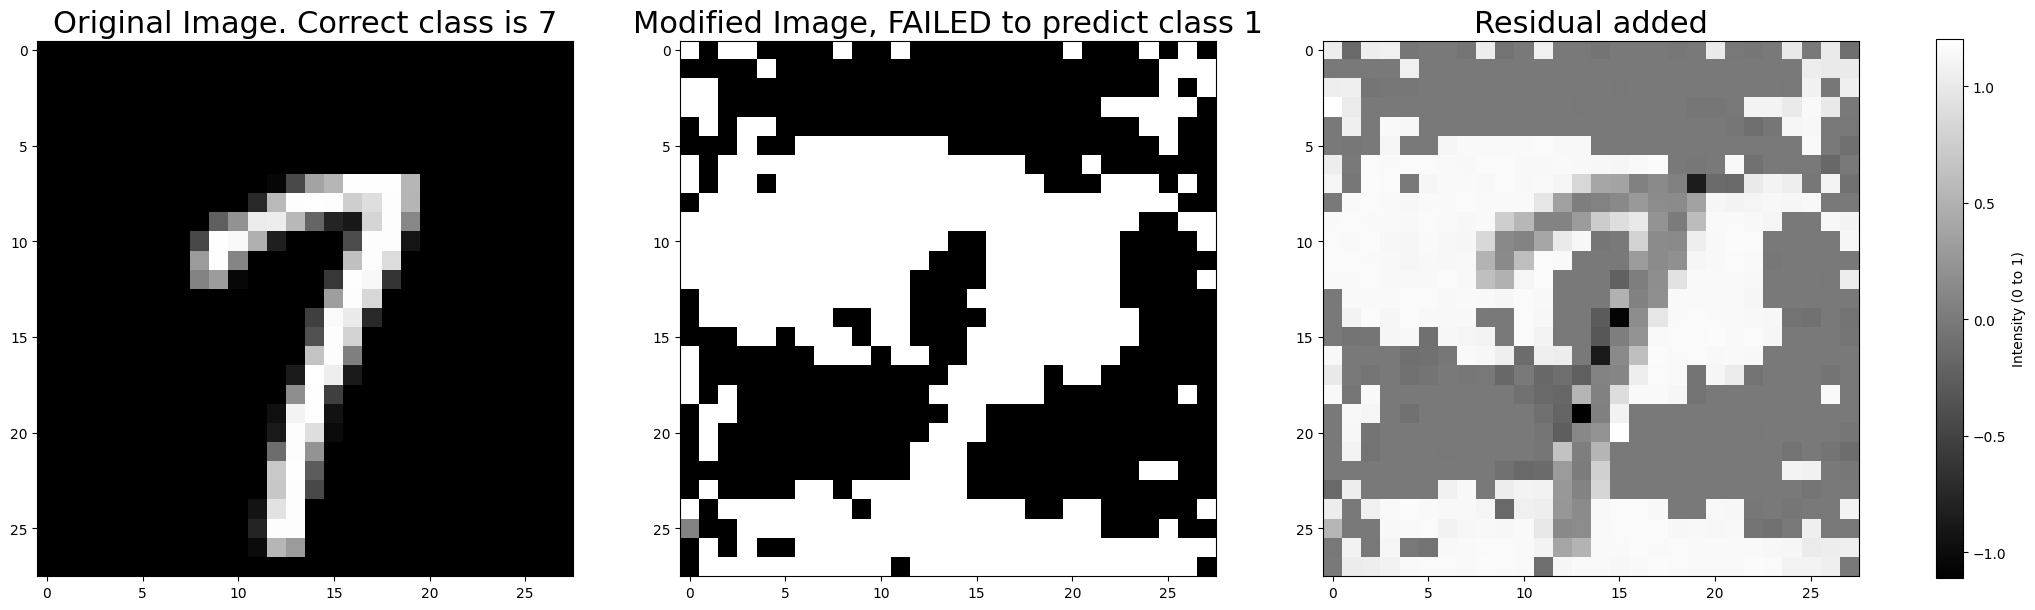

Fixed c: Failed to find adversarial example within the iteration limit.
Optimizing c: Failed to find adversarial example within the iteration limit.


In [33]:
# Run adversarial optimization using Adam
# 1. Fix c and optimize r
print("Fixed c, optimizing r:")
r_fixed_c, x_r_fixed_c, success_fixed_c, c_fixed, iter_fixed = adversarial_optimization_adam(
    model=model,
    testI=testI.to(device),
    testY=testY,
    target_label=1,
    optimize_c=False,
    fixed_c=fixed_c
)

# Visualize results for fixed c
plot_results(
    X=testI.to('cpu'),  # Original image
    r=r_fixed_c.to('cpu'),  # Residual or perturbation
    Xr=x_r_fixed_c.to('cpu'),  # Modified (adversarial) image
    Y=testY,  # Ground truth label (tensor format)
    l=torch.tensor(1),  # Target label wrapped as a tensor
    fail=not success_fixed_c  # Whether the attack failed
)


# 2. Optimize both r and c
print("\nOptimizing both c and r:")
r_opt_c, x_r_opt_c, success_opt_c, c_opt, iter_opt = adversarial_optimization_adam(
    model=model,
    testI=testI.to(device),
    testY=testY,
    target_label=1,
    optimize_c=True
)

# Visualize results for optimized c
plot_results(
    X=testI.to('cpu'),  # Original image
    r=r_opt_c.to('cpu'),  # Residual or perturbation
    Xr=x_r_opt_c.to('cpu'),  # Modified (adversarial) image
    Y=testY,  # Ground truth label (tensor format)
    l=torch.tensor(1),  # Target label wrapped as a tensor
    fail=not success_opt_c  # Whether the attack failed
)


# Results
if success_fixed_c:
    print(f"Fixed c: Optimization succeeded in {iter_fixed} iterations with c = {c_fixed:.6f}")
else:
    print("Fixed c: Failed to find adversarial example within the iteration limit.")

if success_opt_c:
    print(f"Optimizing c: Optimization succeeded in {iter_opt} iterations with c = {c_opt:.6f}")
else:
    print("Optimizing c: Failed to find adversarial example within the iteration limit.")


We see clearly that the approach where we optimize r fixing c gave the wanted results. The perturbation norm was fairly small $|r| \approx 1.21$ proving we end up with a valid adversarial example with minor changes.

Nevertheless, this can't be generalized to the approach where we try to optimize both of r and c. In fact, the perturbation norm is quite large $|r| \approx 19.86$ and we exceeded the maximum iteration number. Thus, let's try to add a regulariztion term and a hyper paramter $\lambda$ for controlling the regularization intensity.

In [34]:
# Modified adversarial optimization using regularization and bounded c
def adversarial_optimization_adam_regularized(
    model, testI, testY, target_label, optimize_c=True, fixed_c=0.001, lr_adam=0.01,
    max_iter_adam=300, reg_lambda=0.01, c_bounds=(1e-6, 0.01)
):
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    c = torch.tensor(fixed_c, requires_grad=optimize_c, device=device)  # Initialize c
    l = torch.tensor([target_label]).to(device).view(1)  # Target label in batch form

    print(f"The true class is {testY}, the new class will be {l[0]}")

    # Check initial prediction
    with torch.no_grad():
        pred = model(testI)
        predicted_label = torch.argmax(pred, dim=1)
        print(f"Initial prediction: {predicted_label.item()}, Target label: {l.item()}")

    if predicted_label.item() == l.item():
        print("The initial prediction already matches the target label. No optimization needed.")
        return r, testI, True, fixed_c, 0

    params = [r]
    if optimize_c:
        params.append(c)
    optimizer = optim.Adam(params, lr=lr_adam)

    success = False
    for iter_count in range(max_iter_adam):
        optimizer.zero_grad()

        # Compute the loss
        x_r = torch.clamp(testI + r, 0, 1)
        logits = model(x_r)
        target_loss = nn.CrossEntropyLoss()(logits, l)
        reg_loss = reg_lambda * torch.norm(r, p=2)
        loss = (c * target_loss + reg_loss) if optimize_c else (fixed_c * target_loss + reg_loss)

        loss.backward()
        optimizer.step()

        # Clamp c if optimizing
        if optimize_c:
            with torch.no_grad():
                c.clamp_(*c_bounds)

        # Evaluate success
        with torch.no_grad():
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)
            if predicted_label.item() == l.item():
                print(f"Success at iteration {iter_count + 1}: Adversarial example found with norm {torch.norm(r, p=2):.4f}")
                success = True
                break

        if iter_count % 20 == 0:
            print(f'Iter {iter_count}/{max_iter_adam}, Loss: {loss.item():.6f}, Norm of r: {torch.norm(r, p=2):.4f}')

    return r, x_r, success, c.item() if optimize_c else fixed_c, iter_count


Optimizing both c and r:
The true class is 7, the new class will be 1
Initial prediction: 7, Target label: 1
Iter 0/300, Loss: 0.008174, Norm of r: 0.2799
Iter 20/300, Loss: 0.000136, Norm of r: 0.1171
Iter 40/300, Loss: 0.000058, Norm of r: 0.0424
Iter 60/300, Loss: 0.000025, Norm of r: 0.0157
Iter 80/300, Loss: 0.000020, Norm of r: 0.0090
Iter 100/300, Loss: 0.000018, Norm of r: 0.0148
Iter 120/300, Loss: 0.000019, Norm of r: 0.0099
Iter 140/300, Loss: 0.000016, Norm of r: 0.0117
Iter 160/300, Loss: 0.000017, Norm of r: 0.0092
Iter 180/300, Loss: 0.000016, Norm of r: 0.0092
Iter 200/300, Loss: 0.000016, Norm of r: 0.0102
Iter 220/300, Loss: 0.000017, Norm of r: 0.0084
Iter 240/300, Loss: 0.000015, Norm of r: 0.0125
Iter 260/300, Loss: 0.000016, Norm of r: 0.0103
Iter 280/300, Loss: 0.000016, Norm of r: 0.0103


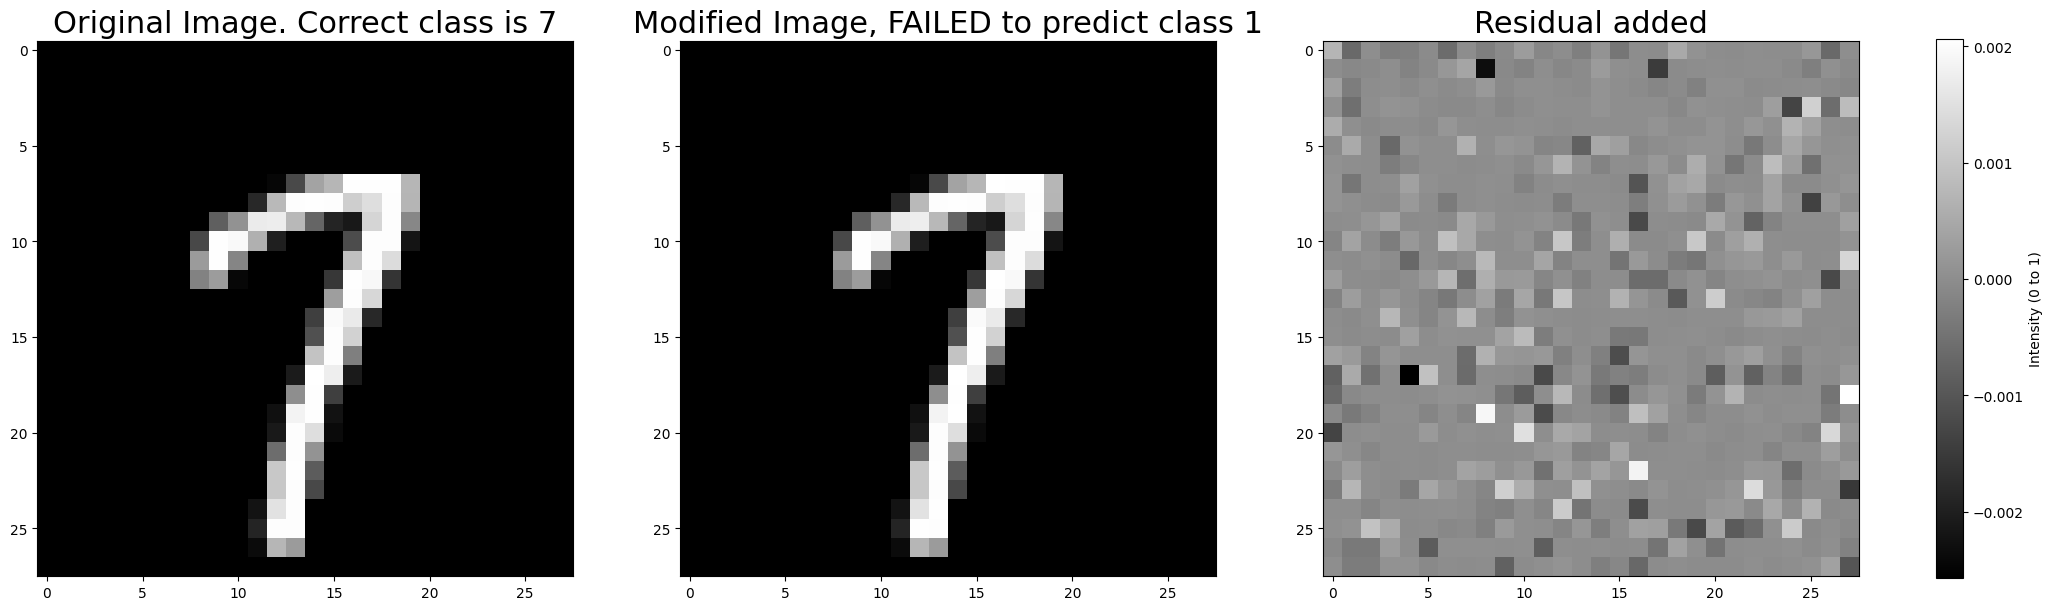

Fixed c: Failed to find adversarial example within the iteration limit.
Optimizing c: Failed to find adversarial example within the iteration limit.


In [35]:
# 2. Optimize both r and c
print("\nOptimizing both c and r:")
r_opt_c, x_r_opt_c, success_opt_c, c_opt, iter_opt = adversarial_optimization_adam_regularized(
    model=model,
    testI=testI.to(device),
    testY=testY,
    target_label=1,
    optimize_c=True,
    reg_lambda=0.001
)

# Visualize results for optimized c
plot_results(
    X=testI.to('cpu'),
    r=r_opt_c.to('cpu'),
    Xr=x_r_opt_c.to('cpu'),
    Y=testY,  # Ground truth label
    l=torch.tensor(1),  # Target label wrapped as a tensor
    fail=not success_opt_c
)


# Results
if success_fixed_c:
    print(f"Fixed c: Optimization succeeded in {iter_fixed} iterations with c = {c_fixed:.6f}")
else:
    print("Fixed c: Failed to find adversarial example within the iteration limit.")

if success_opt_c:
    print(f"Optimizing c: Optimization succeeded in {iter_opt} iterations with c = {c_opt:.6f}")
else:
    print("Optimizing c: Failed to find adversarial example within the iteration limit.")


This is unfortunate, but it seems even though the regularization is working in the sense where the perturbation is small, we can't make the model mispredict the class as 1...

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [36]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

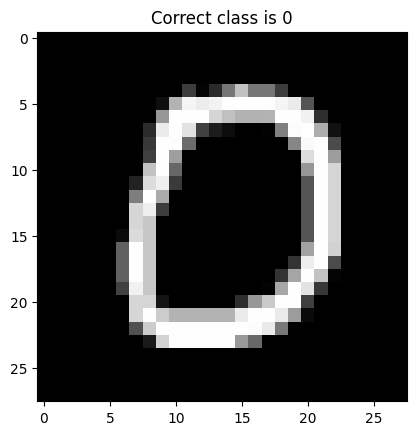

In [37]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

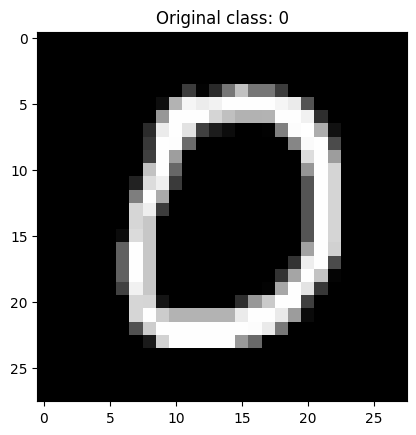

Original Class: 0, Perturbed Class: 5
Optimization successful
Norm Perturbation |r|: 78.4000


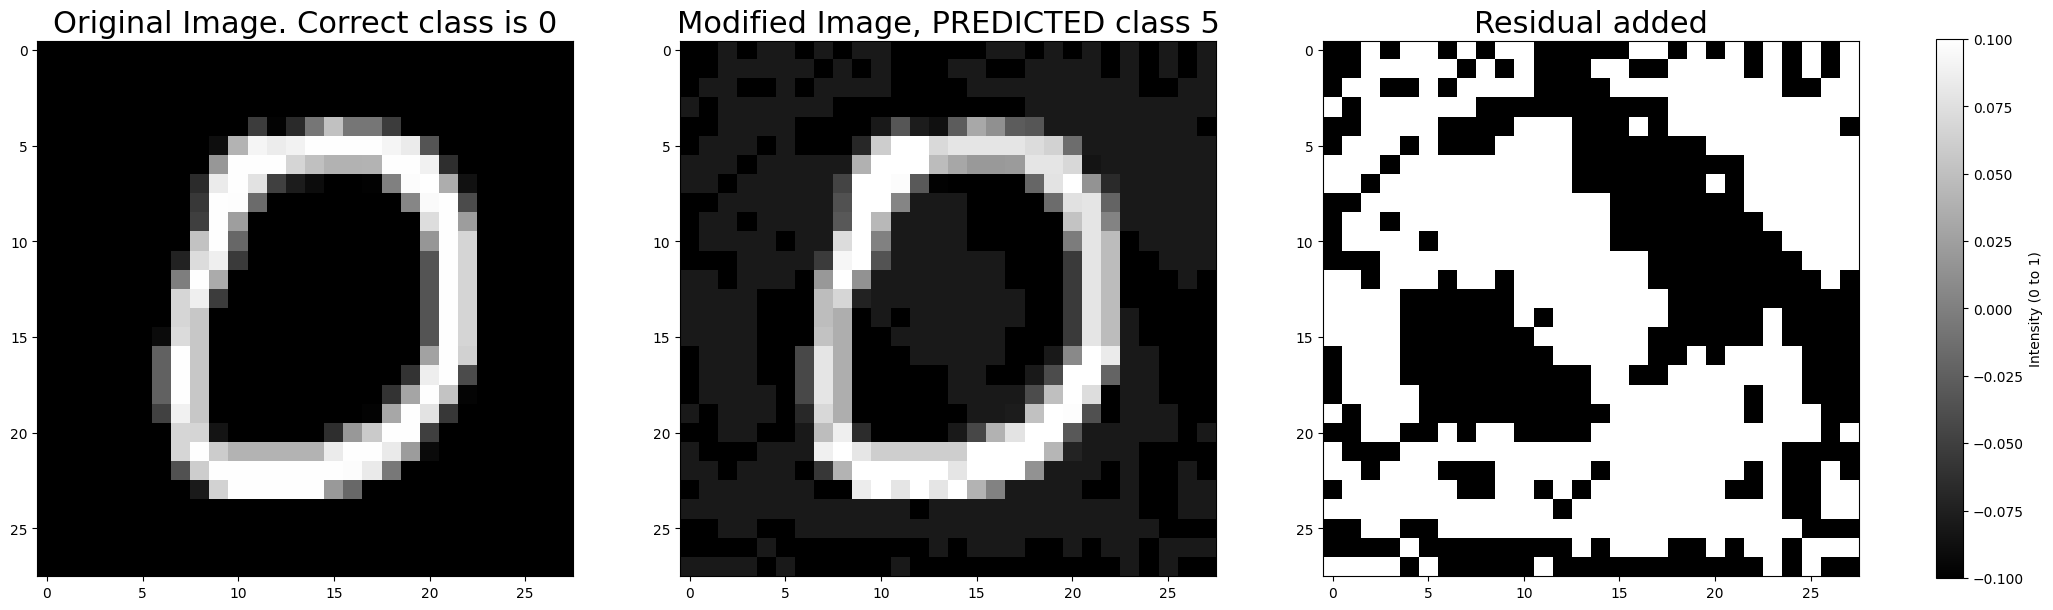

In [38]:
# Parameters
eps = 0.1  # Perturbation size (epsilon)
alpha = 0.5  # Weight for adversarial objective function
index = 10  # Test image index

# Load the test image and label
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)  # Add batch dimension
X.requires_grad = True  # Enable gradient computation
Y = torch.tensor([testY]).to(device)

# Display the original image
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Original class: {testY}")
plt.show()

# Forward pass of X through the model
pred_original = model(X)
original_class = torch.argmax(pred_original, dim=1)

# Compute the loss with adversarial objective
loss_original = nn.CrossEntropyLoss()(pred_original, Y)

# Generate adversarial example: Use adversarial objective with alpha weight
adversarial_loss = alpha * loss_original + (1 - alpha) * nn.CrossEntropyLoss()(
    model(X + eps * torch.sign(torch.autograd.grad(loss_original, X, retain_graph=True)[0])),
    Y
)

# Zero existing gradients
model.zero_grad()

# Compute gradients
adversarial_loss.backward()

# FGSM attack: Perturb the input with the sign of the gradient
r = eps * X.grad.data.sign()  # Calculate perturbation
Xr = torch.clamp(X + r, 0, 1)  # Apply perturbation and clamp to valid range [0, 1]

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class = torch.argmax(pred_perturbed, dim=1)

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

# Evaluate success and visualize
if original_class.item() == perturbed_class.item():
    print("Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.4f}")
    plot_results(
        X=X,  # Original image
        r=r,  # Perturbation
        Xr=Xr,  # Modified (adversarial) image
        Y=testY,  # Ground truth label
        l=perturbed_class,  # Predicted class (tensor format)
        fail=True  # Attack failed
    )
else:
    print("Optimization successful")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.4f}")
    plot_results(
        X=X,  # Original image
        r=r,  # Perturbation
        Xr=Xr,  # Modified (adversarial) image
        Y=testY,  # Ground truth label
        l=perturbed_class,  # Predicted class (tensor format)
        fail=False  # Attack succeeded
    )



Original Class: 0, Perturbed Class: 5
Optimization successful
Norm Perturbation |r|: 196.0000


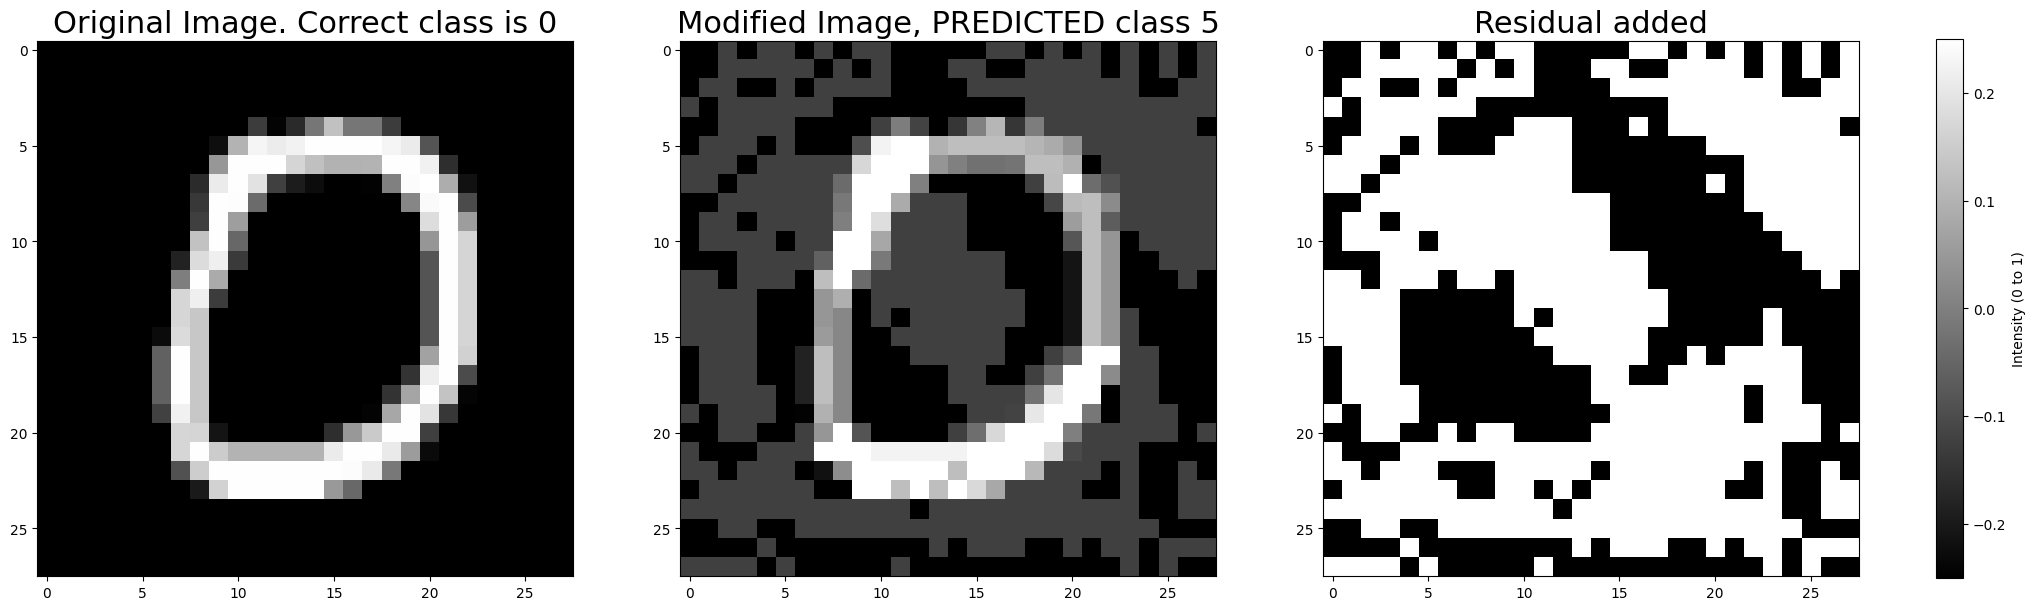

In [39]:
eps = 0.25  # perturbation size

# Forward pass of X through the model
pred_original = model(X)  # Prediction for original image
original_class = pred_original.argmax(dim=1)  # Predicted class for original image

# Ensure testY is a tensor
testY_tensor = torch.tensor([testY], device=X.device)

# Compute loss
cost = torch.nn.CrossEntropyLoss()(pred_original, testY_tensor)  # Cross-entropy loss with ground truth


# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()  # Backpropagation to calculate gradients of the loss with respect to input X

# FGSM attack code
r = eps * X.grad.data.sign()  # Perturbation: scaled sign of the gradient
Xr = X + r  # Perturbed image
Xr = torch.clamp(Xr, 0, 1)  # Ensure pixel values stay in valid range [0, 1]

# Re-classify the perturbed image
pred_perturbed = model(Xr)  # Prediction for perturbed image
perturbed_class = pred_perturbed.argmax(dim=1)  # Predicted class for perturbed image

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

# Evaluate success of the attack
if original_class.item() == perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.4f}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)
else:
    print(f"Optimization successful")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1):.4f}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)


Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created).

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Evaluating epsilon = 0.010...
Using epsilon = 0.010, success rate = 2.87%


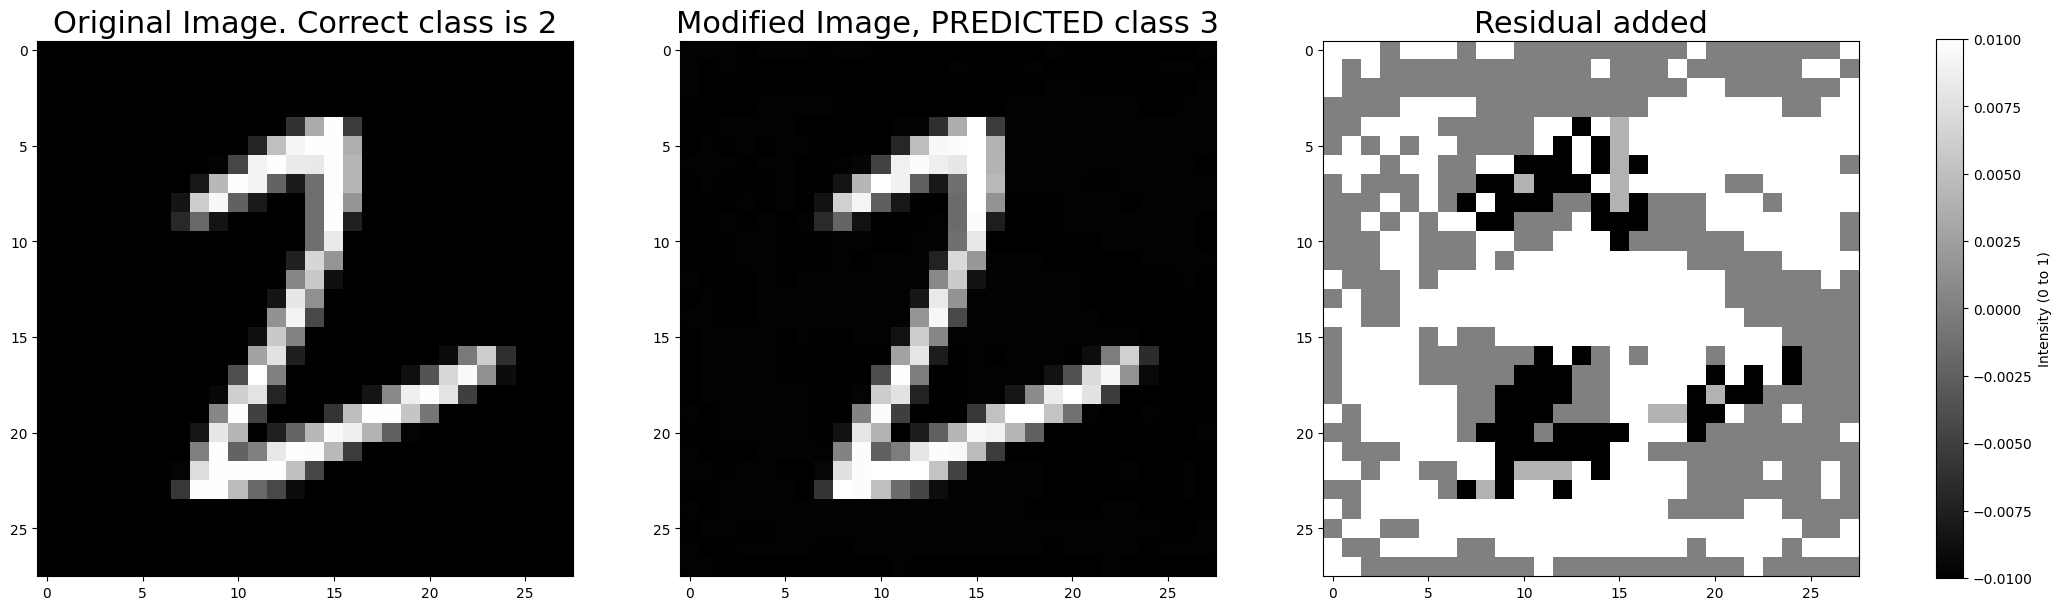

Evaluating epsilon = 0.050...
Using epsilon = 0.050, success rate = 46.79%


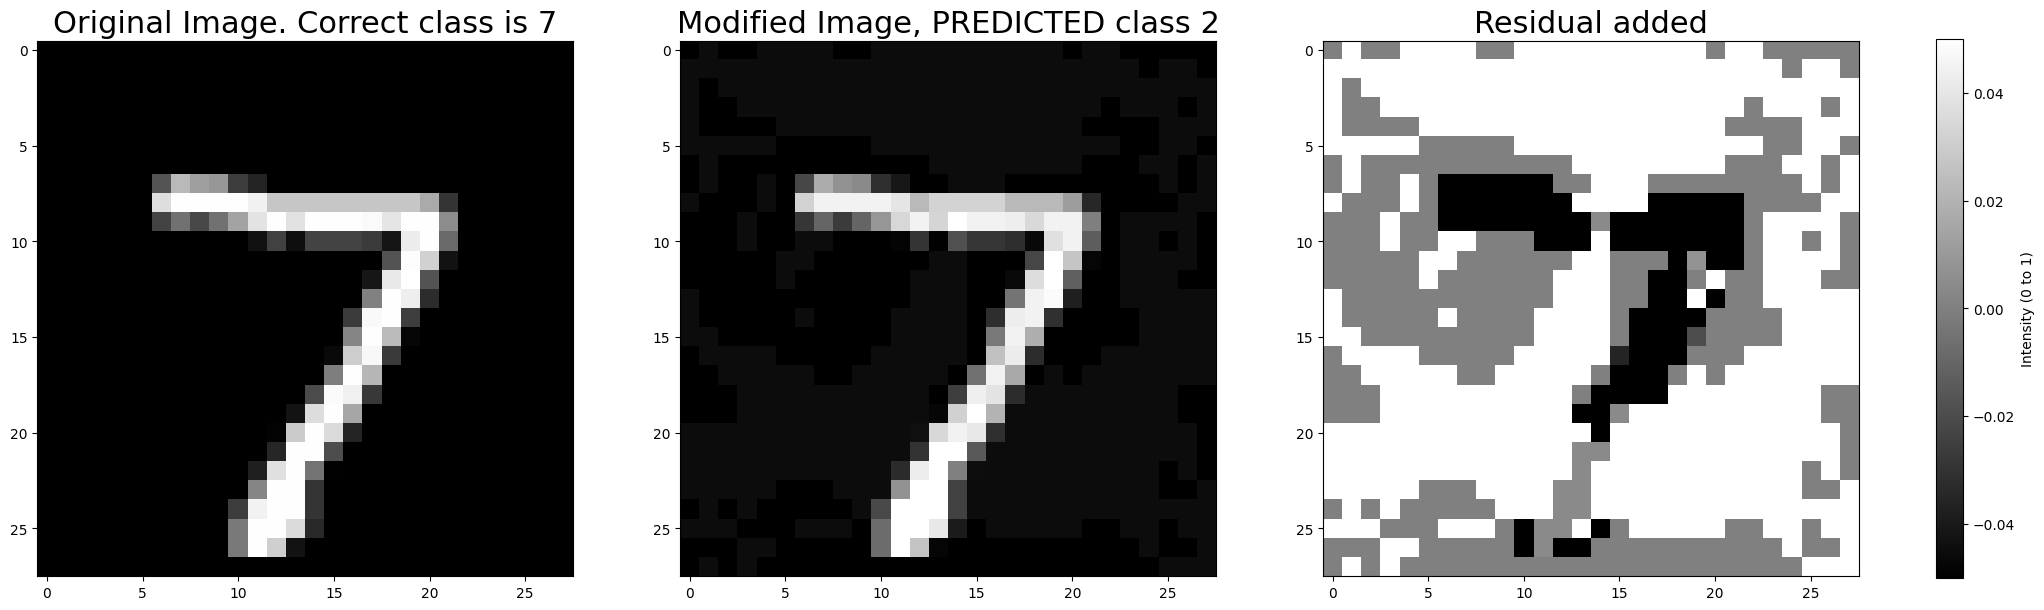

Evaluating epsilon = 0.100...
Using epsilon = 0.100, success rate = 88.25%


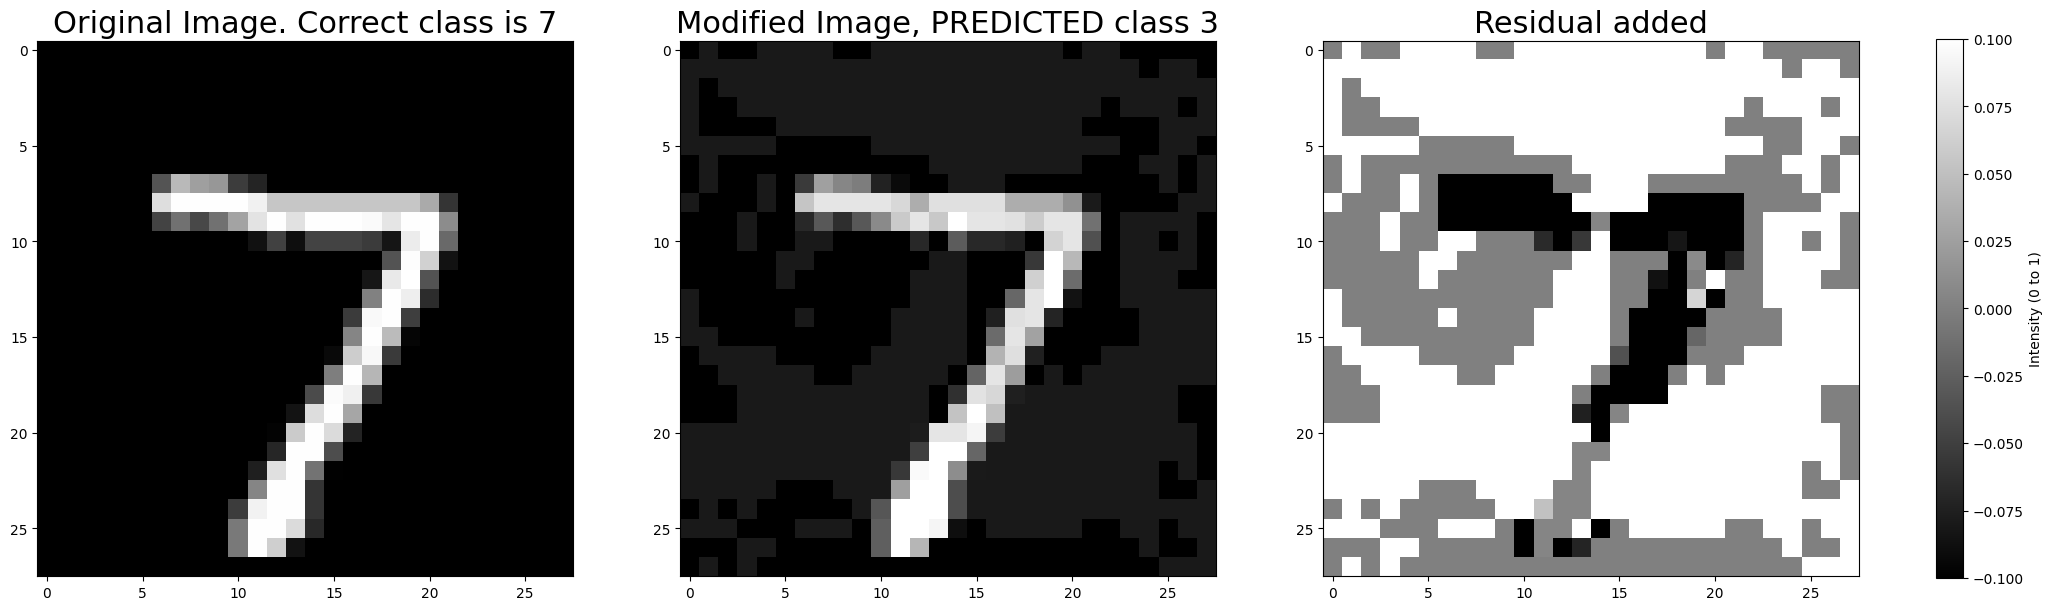

Evaluating epsilon = 0.200...
Using epsilon = 0.200, success rate = 97.40%


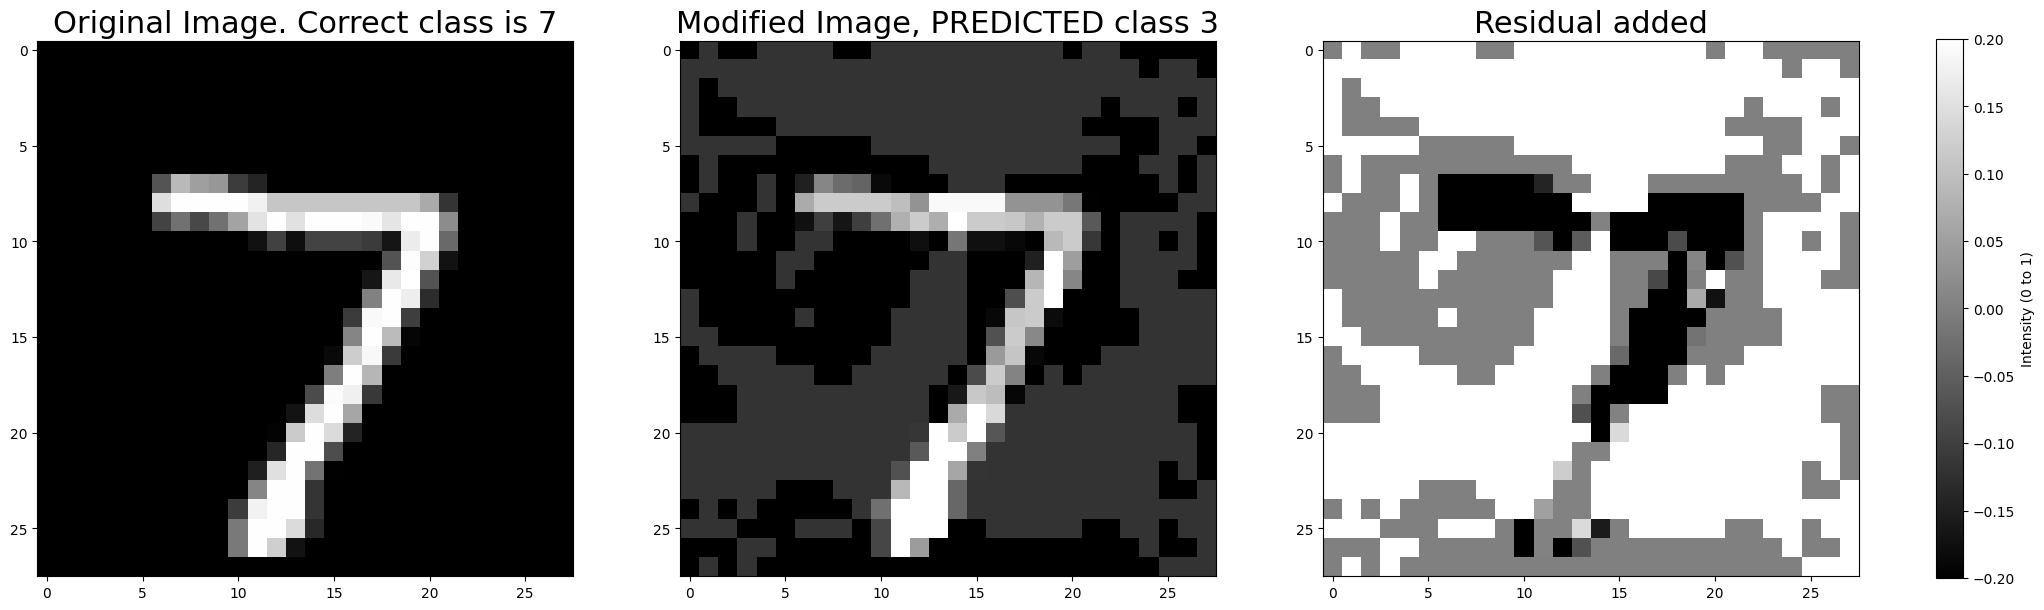

Evaluating epsilon = 0.250...
Using epsilon = 0.250, success rate = 97.72%


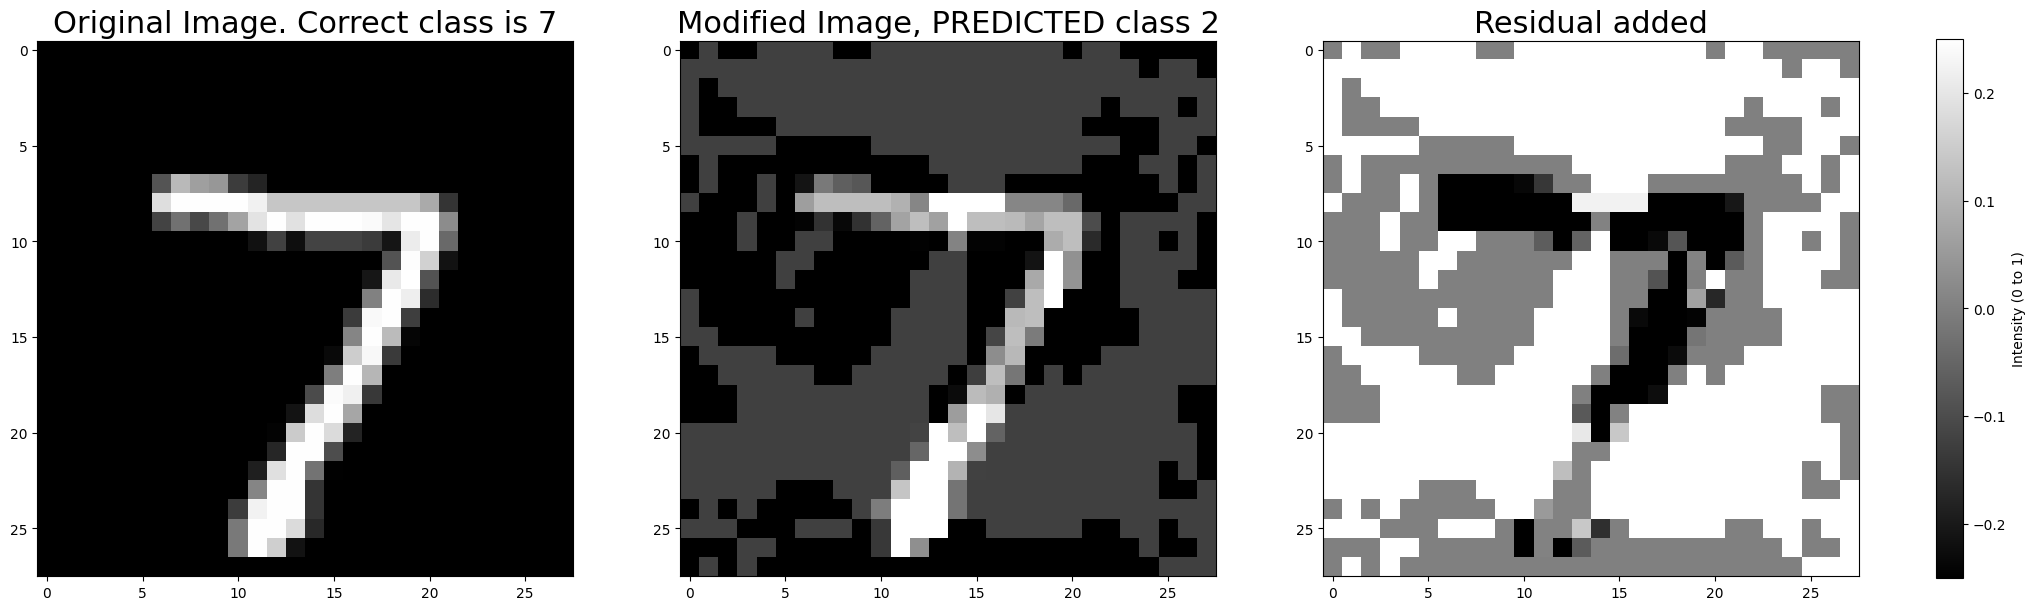

Evaluating epsilon = 0.500...
Using epsilon = 0.500, success rate = 98.30%


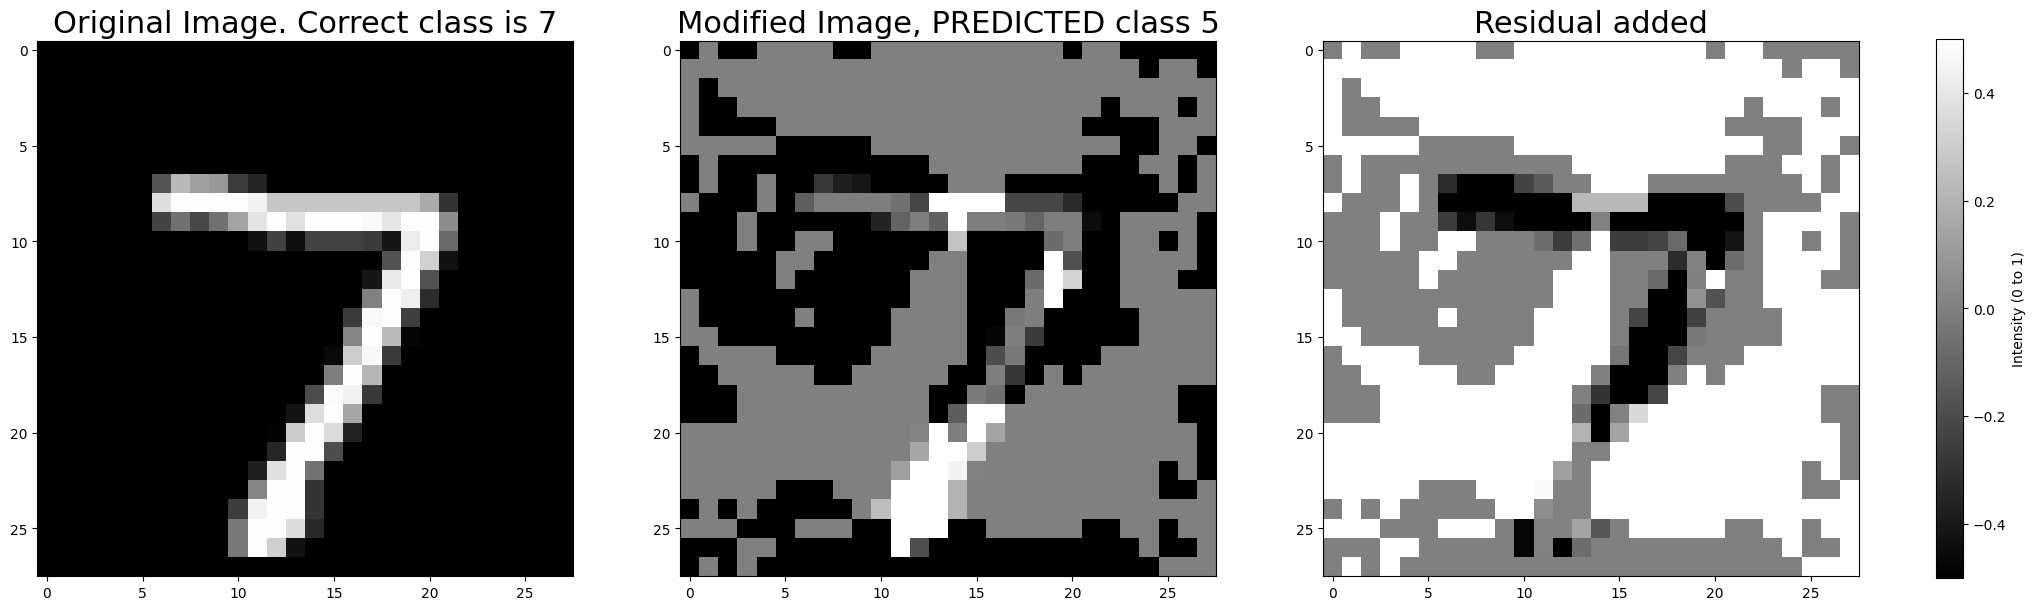

Evaluating epsilon = 1.000...
Using epsilon = 1.000, success rate = 98.66%


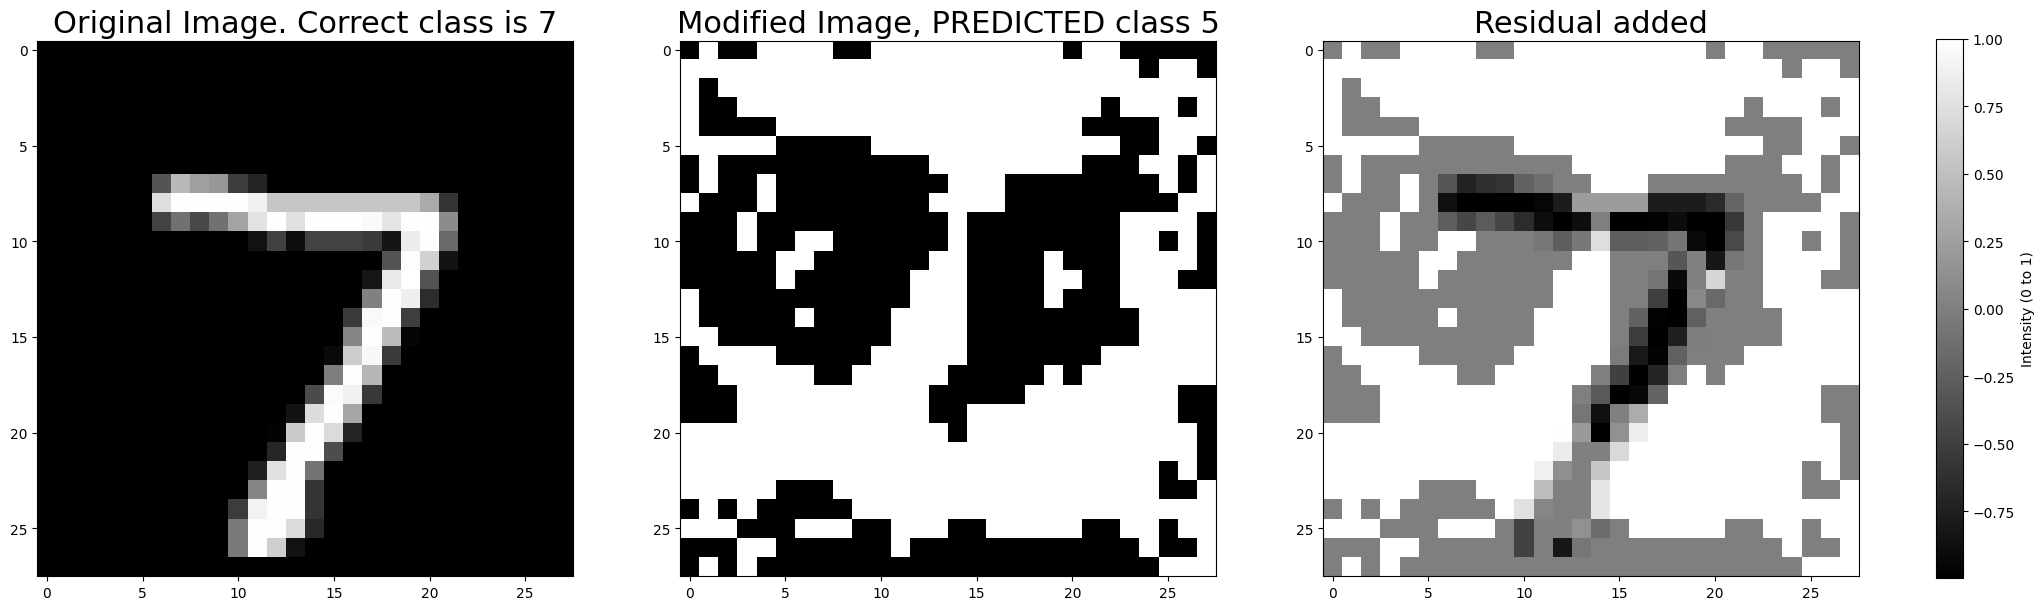

Evaluating epsilon = 1.100...
Using epsilon = 1.100, success rate = 98.66%


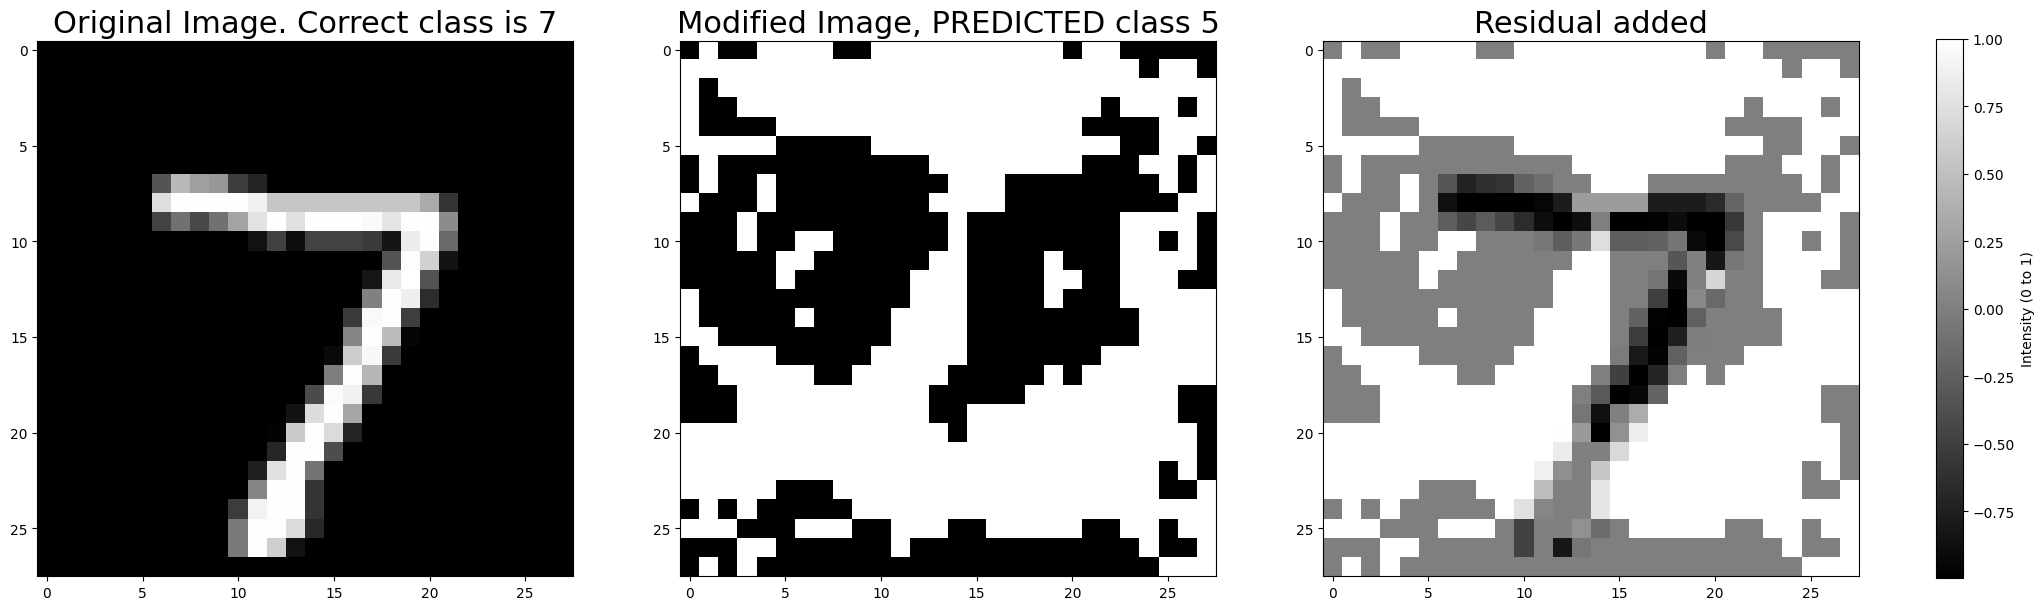

Evaluating epsilon = 1.200...
Using epsilon = 1.200, success rate = 98.66%


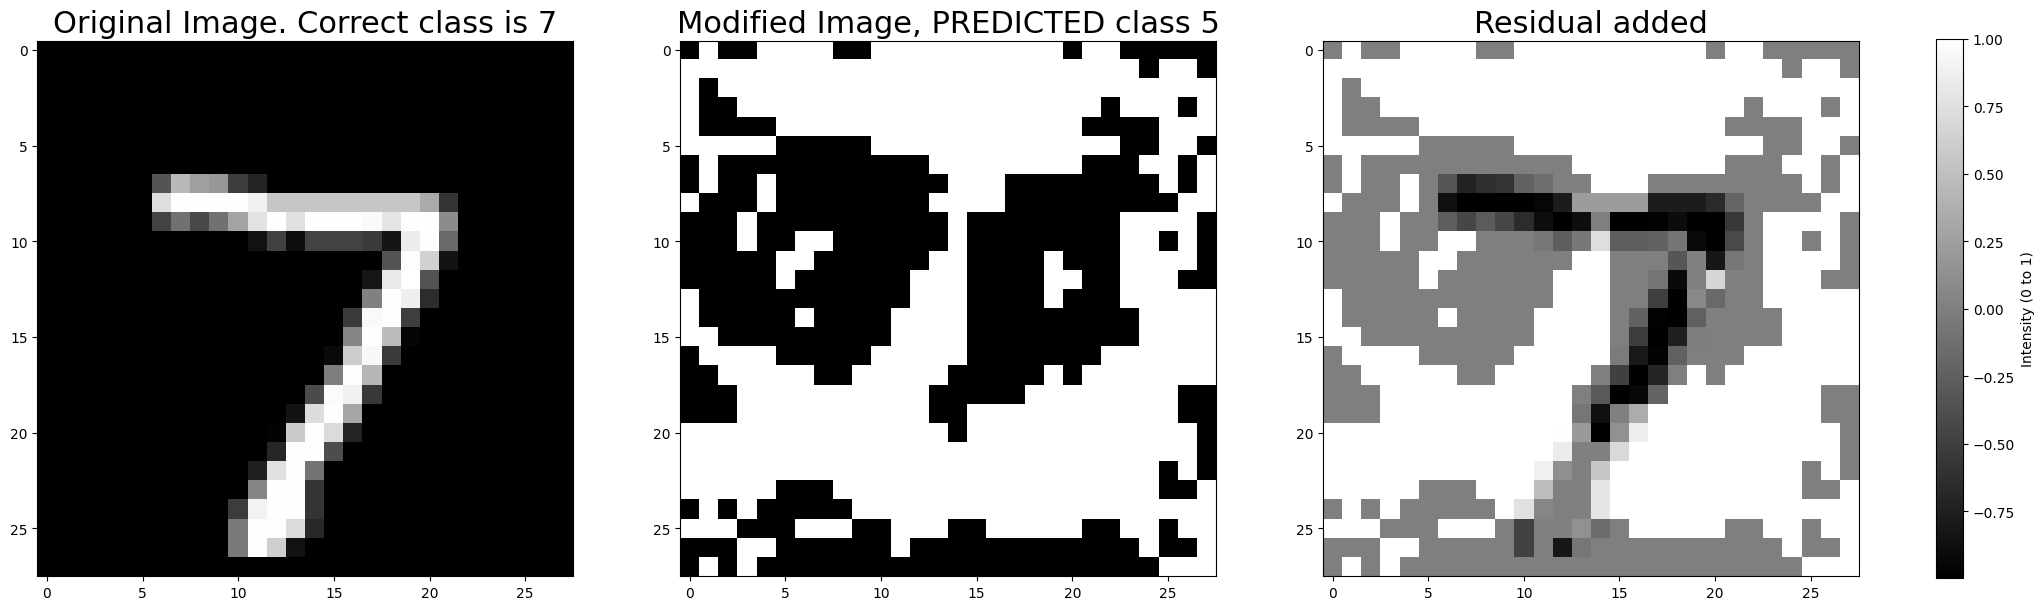

Evaluating epsilon = 1.300...
Using epsilon = 1.300, success rate = 98.66%


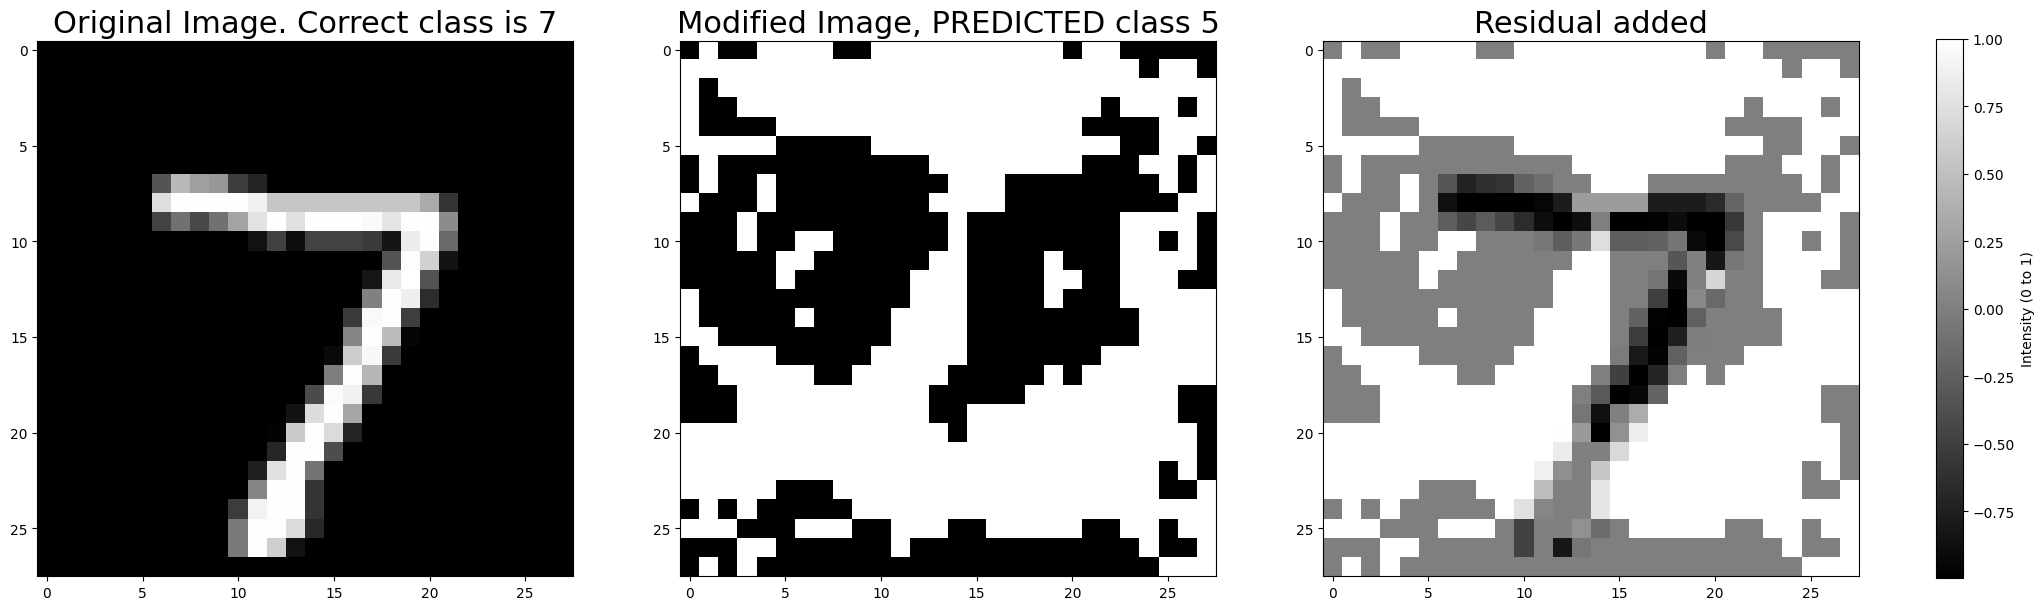

Evaluating epsilon = 1.400...
Using epsilon = 1.400, success rate = 98.66%


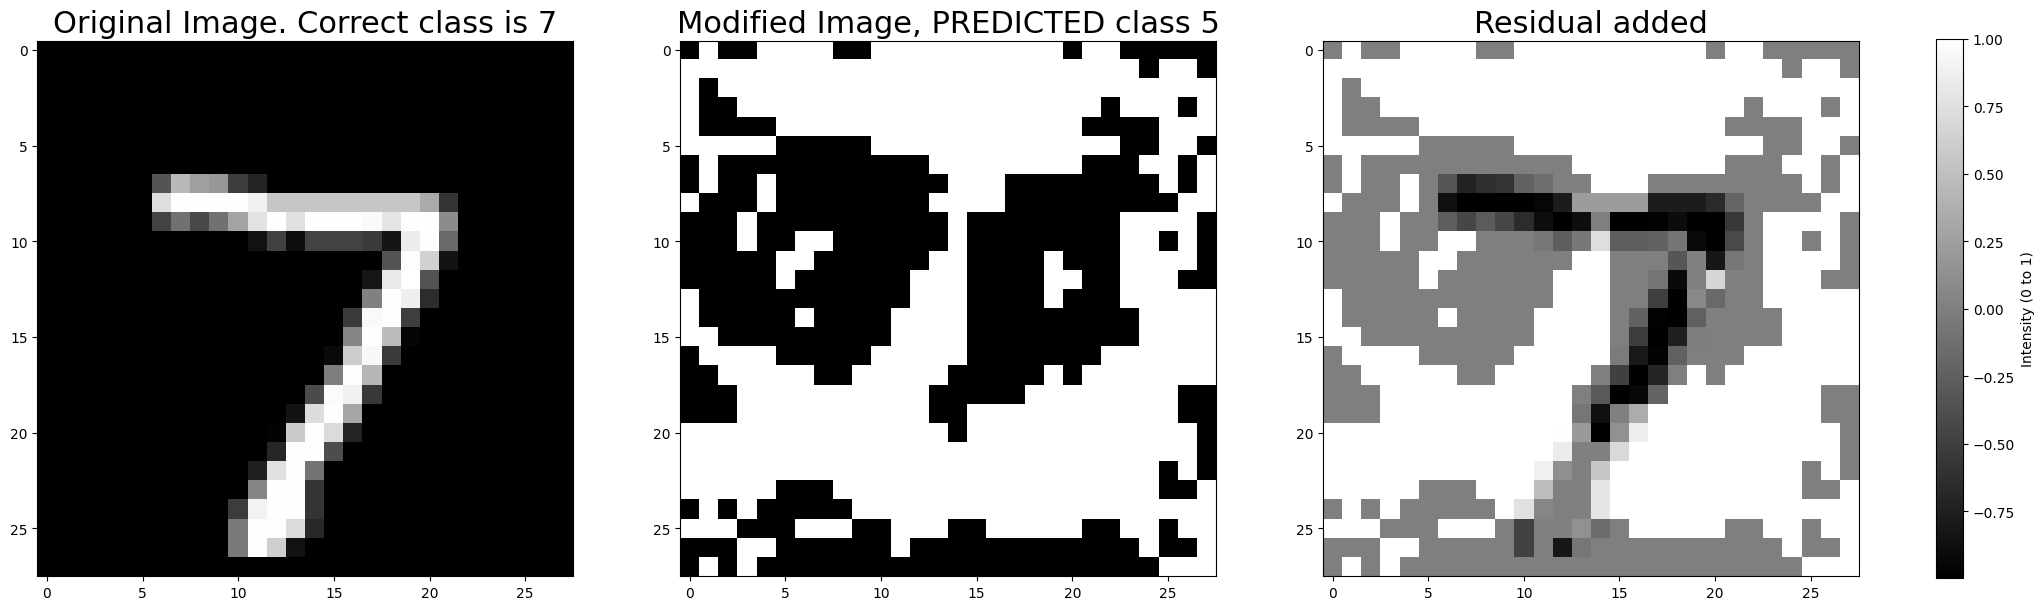

Evaluating epsilon = 1.500...
Using epsilon = 1.500, success rate = 98.66%


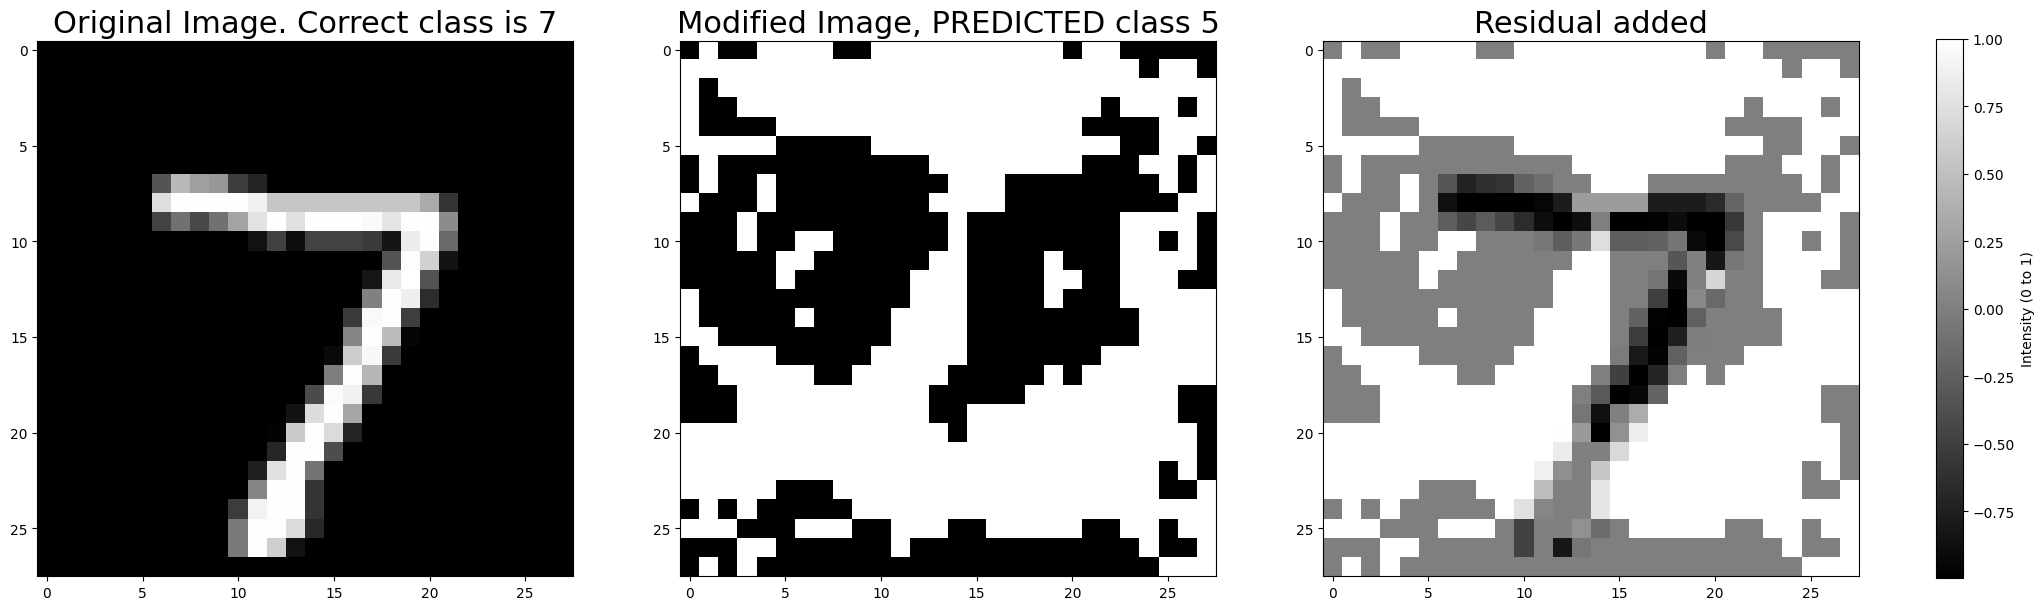


Best epsilon: 1, Success rate: 98.66%


In [43]:
# FGSM attack function
def fgsm_attack(X, Y, model, loss_model, eps):
    """
    Perform FGSM attack on a single input X with label Y.
    Args:
        X (torch.Tensor): Input image.
        Y (torch.Tensor): True label.
        model (torch.nn.Module): Trained model.
        loss_model (torch.nn.Module): Loss function (e.g., CrossEntropyLoss).
        eps (float): Perturbation size.

    Returns:
        Xr (torch.Tensor): Adversarial example.
        original_class (int): Original predicted class.
        perturbed_class (int): Perturbed predicted class.
        r (torch.Tensor): Perturbation applied to X.
    """
    X = X.unsqueeze(0).to(device)  # Add batch dimension and move to device
    Y = torch.tensor([Y]).to(device)

    X.requires_grad = True  # Enable gradient computation

    # Forward pass and compute loss
    pred_original = model(X)
    original_class = torch.argmax(pred_original, dim=1)
    loss = loss_model(pred_original, Y)

    # Zero gradients and backpropagate
    model.zero_grad()
    loss.backward()

    # Generate adversarial example
    r = eps * X.grad.data.sign()  # Perturbation
    Xr = torch.clamp(X + r, 0, 1)  # Perturbed image clamped to [0, 1]
    pred_perturbed = model(Xr)
    perturbed_class = torch.argmax(pred_perturbed, dim=1)

    return Xr, original_class, perturbed_class, r


# Evaluate success rate for FGSM attack
def evaluate_fgsm(eps_values, model, test_loader, loss_model):
    """
    Evaluate FGSM attack success rate for a range of epsilon values.

    Args:
        eps_values (list of float): List of epsilon values to test.
        model (torch.nn.Module): Trained model.
        test_loader (DataLoader): Test data loader.
        loss_model (torch.nn.Module): Loss function (e.g., CrossEntropyLoss)

    Returns:
        results (dict): Dictionary containing success rates for each epsilon.
    """
    results = {}
    for eps in eps_values:
        print(f"Evaluating epsilon = {eps:.3f}...")

        # Initialize counters
        successful = 0
        total = 0
        adv_examples = []

        # Loop over all examples in the test set
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # Move batch to device
            for X, Y in zip(X_batch, Y_batch):
                Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)
                total += 1

                # Count successful adversarial examples
                if original_class.item() != perturbed_class.item():
                    successful += 1
                    adv_examples.append((X.to('cpu'), Xr.to('cpu'), Y.to('cpu'), perturbed_class.to('cpu')))

        # Calculate success rate
        success_rate = 100.0 * successful / total
        results[eps] = success_rate
        print(f"Using epsilon = {eps:.3f}, success rate = {success_rate:.2f}%")

        # Plot one example for visualization
        if len(adv_examples) > 0:
            X, Xr, Y, perturbed_class = adv_examples[0]
            plot_results(X, Xr - X, Xr, Y, perturbed_class, fail=False)

    return results


# Define epsilon values to test
eps_values = [0.01, 0.05, 0.1, 0.2,0.25,0.5,1,1.1,1.2,1.3,1.4,1.5]

# Evaluate FGSM attack success rate
results = evaluate_fgsm(eps_values, model, test_loader, nn.CrossEntropyLoss())

# Find the best epsilon
best_eps = max(results, key=results.get)
print(f"\nBest epsilon: {best_eps}, Success rate: {results[best_eps]:.2f}%")


As $\epsilon$ increases, the success rate increases as well until it stagnates at 98.66% for $\epsilon \gt 1$. However, we notice that the modified image gets worse little by little to the point we can't recognize the ground truth label with the naked eye. In fact, starting from $\epsilon=0.2$, we can notice visible distortion of the pixels that are grey and neither white nor black, but still, we can be over-confident of the label so that's okay. But, starting from $\epsilon=1$, we can't recognize the label at all, the pixels are in total chaos!